In [2]:
import numpy as np
from matplotlib import pyplot as plt
#import matplotlib as plt
#%matplotlib notebook
#%matplotlib qt
from pprint import pprint

#from __future__ import division


import os
os.listdir(os.getcwd())

import csv as csv
import json as json
import pickle as pickle

import scipy as scipy
from scipy.signal import find_peaks

C:\Python37\lib\site-packages\numpy\_distributor_init.py:32: UserWarning: loaded more than 1 DLL from .libs:
C:\Python37\lib\site-packages\numpy\.libs\libopenblas.4SP5SUA7CBGXUEOC35YP2ASOICYYEQZZ.gfortran-win_amd64.dll
C:\Python37\lib\site-packages\numpy\.libs\libopenblas.XWYDX2IKJW2NMTWSFYNGFUWKQU3LYTCZ.gfortran-win_amd64.dll
  stacklevel=1)


In [3]:
## PLAN ##
# I could import the voltage file to get the light data--probably a good idea
# Otherwise I'm going to cut all the plots except raw and just get the time of peaks


## Import data

In [4]:
##open all files


#get to folder
date = '20210726'
date_code = 'b-0726'  #for fly names (b for bruker 4 code date and fly #)
Pathstart = '/Users/ashsm/Documents/Stanford/PER timing project/Bruker videos/' + str(date) + '/analysis'
print(Pathstart)
files = os.listdir(Pathstart)
print(files)
SavePath = '/Users/ashsm/Documents/python analysis/bruker analysis' 
data_reducer = 100 #value to reduce the amount of voltage data imported

#make a list of filenames
file_name_list = []
for i in range(len(files)):
    if '.csv' in files[i]: 
        csv_file = []
        csv_file = files[i]
        file_name_list.append(csv_file)
        print (files[i])
    else:
        print('no')
print('file name list', file_name_list)

##Bruker change, add light_data

data_all = []
light_data = []
for single_file in file_name_list:
    with open(os.path.join(Pathstart, single_file), 'r') as rawfile:  #'rb' in python2
       # reader = csv.reader(psth, delimiter="\t")
        reader = csv.reader(rawfile)
        
        if 'Results' in single_file:
            data_single = list(reader)
            data_all.append(data_single)
        elif 'Voltage' in single_file:  #will need to sort out the fly order later
            data_single = []
            for i, row in enumerate(reader):
                if i % data_reducer == 0:  #this will downsample the data by taking every 100, i % 100 means will divide i by 100 and take the ones that have no remainder
                    data_single.append(row)
            light_data.append(data_single)
#print('intdata', intdata)
print(len(data_all))
print(len(file_name_list))



##I could alternatively open files when I need them rather than storing them all in memory...

/Users/ashsm/Documents/Stanford/PER timing project/Bruker videos/20210726/analysis
['fly1_20s-011_Cycle00001_VoltageRecording_001', 'Results_video_1_python.csv', 'video_1_ROI_image.png']
no
Results_video_1_python.csv
no
file name list ['Results_video_1_python.csv']
1
1


## set framerate

In [5]:
##I think I can remove this doubleflash stuff
# #If there are double flashes set as True
# double_flash = False
# time_to_discount = 3000  #time to discount if double flash
# #take_first_pulse = True #True if want to take the first pulse as the start, False if w

voltage_framerate =  10000/data_reducer #frames/s # 1frame/.1ms * 1000ms/1s = 10000f/s
#with reducer i get 1 frame for every .1 * 100 ms => frame/.1*100 ms * 1000ms/s = 100f/s
#each "frame" is 0.1ms
video_framerate = 200 #f/s


############# CURRENTLY THIS DOESN"T WORK BECAUSE I HAVE voltage and behavior seperately added. Do I want to do this?
### I can always just ask for framerate with voltage_framerate or video_framerate
# would this be easier than using framerate_list?

##set framerate
framerate_list = []
for single_video_index in range(len(data_all)):
    if 'Voltage' in file_name_list[single_video_index]:
        print('adding voltage framerate')
        framerate_list.append(voltage_framerate)
    elif 'video' in file_name_list[single_video_index]:
        framerate_list.append(video_framerate)
        print('adding bruker vid framerate')
    else:
        print("specify framerate for :", file_name_list[single_video_index])
print(framerate_list)
print(file_name_list)
print(len(data_all))

adding bruker vid framerate
[200]
['Results_video_1_python.csv']
1


## set the interval time

In [6]:
# add the filename of the video to the dictionary with the length of the interval in s as the key

list_map = {
    #'none': ['Results_video_2_python.csv'] # the dictionary key tells you what kind of video it is
    20: ['Results_video_1_python.csv'],
    #20: ['Results_video_1_python.csv']
}
def get_intervals_and_asks(list_map, file_name_list):
    """Get the PER interval and the ask type for each file in file_name_list.
    
    Args:
      list_map: A Dict of {interval: [list of filenames]} where interval is either the
        length of the interval in seconds or one of the strings {'random', 'none'}.
      file_name_list: A List of string filenames. The order determines the order of the output.
    Returns:
      A tuple of lists (interval_ms_list, ask) ordered to match file_name_list.
      interval_ms_list: a list of the interval length in milliseconds for each result in file_name_list
      ask: a list of ask types: 0 for fixed intervals, 'r' for random, and 'y' for none.
    """
    interval_ms_list = []
    ask = []
    for file_name in file_name_list:
        for key in list_map:
            if file_name in list_map[key]:
                if isinstance(key, str): # using strings to pass special values
                    if key == 'none' or 'y':
                        interval_ms_list.append(0)
                        ask.append('y')
                    if key == 'random':
                        interval_ms_list.append(0)
                        ask.append('r')
                else:  # if the key is not a string, it must be a number.
                    interval_ms_list.append(key * 1000)
                    ask.append(0)
                #print(key, file_name, interval_ms_list[-1], ask[-1]) # optional if you like to print stuff.
    return interval_ms_list, ask
interval_ms_list, ask = get_intervals_and_asks(list_map, file_name_list)

print(interval_ms_list)
print(ask)

[20000]
[0]


In [7]:
## there is only one fly per bruker vid so I am removing the info to designate fly numbers



fly_number_list = []
for i in range(len(data_all)):
    fly_number = str(date_code) + '-' + str(i+1)
    fly_number_list.append(fly_number)
print(fly_number_list)



['b-0726-1']


In [8]:
# ##this is very specific--figure out the fly2 thing later and append or something

# for file_index in range(len(file_name_list)):
#     if 'VoltageRecording' in file_name_list[file_index] and 'fly2' in file_name_list[file_index]:
#         #print(file_data)
#         light_file_index = file_index
# print(light_file_index)

In [9]:
## list of functions to run before PER_analysis



def make_bins (time_range, binsize):
    """to make bins based on desired time range and binsize--use ms"""
    ms_binlength = np.asarray(range(int(time_range/binsize) + 1)) * binsize
    return ms_binlength

#to see if the column is a mean
def is_column_mean (data, row, column):
    """return true if cell contains 'mean'"""
    return "Mean" in data[row][column] or "diode" in data[row][column]  #diode added for bruker

#collecting all of the values in a column
def get_means(data, column_number):  #this will pull from whatever you call the variable that you have gotten your csv data from and specified column 
    mean_list = []
    """gets column for (data, column_number) and eliminates the header (row 0) and puts it into a np.array"""
    for row in data: #row is the variable with the row number in it if use range(len(data)) it gives a list of the row if just use data
        #print row
        mean_list.append(row[column_number])
    means = np.asarray(mean_list[1:], dtype=np.float) #changes the list into a numpy array. [1:] means take the second number to the end 
    #(to get rid of the title). dtype changes from strings to np integers
    return means

def get_header(data, column_number):  #this will pull from whatever you call the variable that you have gotten your csv data from and specified column 
    title_list = []
    """gets header (row 0) for data set for specified column (data, column number)"""
    for row in data: #row is the variable with the row number in it if use range(len(data)) it gives a list of the row if just use data
        #print row
        title_list.append(row[column_number])
    titles = np.array(title_list[:1]) #changes the list into a numpy array. [:1] means take the first row
    return titles

def get_video_name(data, column):  #this will pull from whatever you call the variable that you have gotten your csv data from and specified column 
    video_name = []
    """gets video name (row 2) for data set for specified column (data, column number)--specify column 2 (1)"""
    for row in data: #row is the variable with the row number in it if use range(len(data)) it gives a list of the row if just use data
        #print row
        video_name.append(row[column])
    video = np.array(video_name[1:2]) #changes the list into a numpy array. [1:2] means take the second row
    return video

# # find the mean(light) columns
# def is_column_light (data, row, column):
#     """return true if the column contains 'light' or 'Light'"""
#     return "Light" in data[row][column] or "light" in data[row][column]

# find the mean(light) columns
##bruker addition
def is_column_light (data, row, column):
    """return true if the column contains 'light' or 'Light'"""
    return "Light" in data[row][column] or "light" in data[row][column] or " diode" in data[row][column]


##specify which columns are PER by checking the column numbers in mean_titles
def is_column_PER (data, row, column):
    """return true if the column contains 'PER)' or 'per)' or 'Per)'"""
    return "PER)" in data[row][column] or "per)" in data[row][column] or 'Per)' in data[row][column]
    #in the fiji files the title is Mean(PER) so the ) lets it distinguish between PER and PER#

def is_column_PER2 (data, row, column):
    """return true if the column contains 'PER2' denoting second fly's PER"""
    return "PER2)" in data[row][column]

def is_column_PER3 (data, row, column):
    """return true if the column contains 'PER3' denoting third fly's PER"""
    return "PER3)" in data[row][column]

def is_column_PER4 (data, row, column):
    """return true if the column contains 'PER4' denoting fourth fly's PER"""
    return "PER4" in data[row][column]

def is_column_PER5 (data, row, column):
    """return true if the column contains 'PER2' denoting second fly's PER"""
    return "PER5" in data[row][column]





def make_title (date, video, fly_id, interval_s):
    title = str(date) + str(video).strip('[]') + str(fly_id) + '-flyID_' + str(interval_s) + '_int'
    return title

In [10]:
##functions that make things or process data

def make_raw_plots (PER_index, fly_number, split, save):
    """make raw plots--input PER(#)_indices, fly number, and if the plot should be split (y or n or b (both)) 
    and if it should be saved (y or n or b)"""
    #set up variables
    xtime = np.arange(1,len(means_matrix)+1)*framerate
    yPERm = means_matrix[:,PER_index]
    ylightm = means_matrix[:,light_indices] 
    yPERm_label = mean_titles[:,PER_index]
    ylightm_label = mean_titles[:,light_indices]
    #x and y for smoothed data
    #x2time = np.arange(1,len(smoothed_intensity_increases)+1)*framerate
    x2time = np.arange(1,len(smoothed_intensity_increases))*framerate  #using find_peaks don't drop last frame
    ysmoothlight = smoothed_intensity_increases[:,light_indices]*100 ##choosing a multiplier so I can see it compared to the line of PERintensity amp
    ysmoothlight_label = mean_titles[:,light_indices],'smooth increase'
    yuplight = intensity_up_50[:,light_indices_int]
    yuplight_label = mean_titles[:,light_indices],'intensity increase'
    ysmoothPER = smoothed_intensity_decreases[:,PER_index]*250 ##choosing different multiplier so I can see it compared to PERintensity and is differnt from y4
    ysmoothPER_label = mean_titles[:,PER_index],'smooth decrease'
    halfpoint = (max(xtime)/2)
    endpoint = max(xtime)
    
    
    
    
    #add to dictionary data_dict
    data_dict['light on frames'] = np.nonzero(intensity_up_50[:,light_indices_int])
    data_dict['raw PER'] = means_matrix[:,PER_index]
    #data_dict['raw light'] =map(float, means_matrix[:,light_indices].tolist())
    data_dict['raw light'] =means_matrix[:,light_indices]
          
    
    
    #make title
    title = make_title(date, video, fly_number, interval_s)
    
    if split == 'n' or split == 'b':
        print('full-raw' + str(fly_number))
        #plotting full plot
        fig2 = plt.figure(figsize=(50,30))
        plt.plot(xtime,ylightm,label = ylightm_label, color = 'darkorange', zorder = 1)   ##plots the light on/off lines from raw
        plt.plot(xtime,yPERm,label = yPERm_label, color = 'dodgerblue', zorder = 2)       ##plots the PER out/in lines from raw
        plt.scatter(xtime, ysmoothPER, color = 'k', zorder = 3)
        
        #plt.scatter(x2time,ysmoothPER, s=1, label = ysmoothPER_label, color = 'k', zorder = 3)  ##plots the points where found PER intensity decrease
        ##plt.scatter(x2time,yuplight, label = yuplight_label)  ##can't do this one because the length is different. fix length to plot with PER
        #plt.scatter(x2time,ysmoothlight, label = ysmoothlight_label)
        plt.xlabel('time (ms)')
        plt.ylabel('intensity changes')
        plt.title(str(title) + '_full-raw-plot')
        plt.show()
        if save == 'y':
            ##make path for saving the files
            #Path = '/Users/ashsm/Documents/python analysis/new-code-test'
            rawPath = SavePath + "/" + str(date) + "/raw"
            if os.path.exists(rawPath):
                print('folder there')
            else:
                os.makedirs(rawPath)
            fig2.savefig(os.path.join(rawPath, str(title) + '_full-raw.png'))
        else:
            print('full raw not saved  :'+ str(fly_number))
        
    if split == 'y' or split == 'b':
        print('part-1-raw' + str(fly_number))
        #plot split plots
        #first half
        fig2 = plt.figure(figsize=(50,30))
        plt.plot(xtime,ylightm,label = ylightm_label, color = 'darkorange', zorder = 1)
        plt.plot(xtime,yPERm,label = yPERm_label, color = 'dodgerblue', zorder = 2)
        #plt.scatter(x2time,ysmoothlight, s=1, label = ysmoothlight_label, color = 'c')
        plt.scatter(xtime, ysmoothPER, color = 'k', zorder = 3)

        #plt.scatter(x2time,ysmoothPER, s=1, label = ysmoothPER_label, color = 'k', zorder = 3)
        plt.xlabel('time (ms)')
        plt.ylabel('intensity_up')
        plt.title(str(title) + '_part-1-raw') 
        plt.xlim(0,halfpoint)
        plt.show()
        if save == 'y':
            ##make path for saving the files
            #Path = '/Users/ashsm/Documents/python analysis/new-code-test'
            rawPath = SavePath + "/" + str(date) + "/raw"
            if os.path.exists(rawPath):
                print('folder there')
            else:
                os.makedirs(rawPath)
            fig2.savefig(os.path.join(rawPath, str(title) + '_part-1-raw.png'))
        else:
            print('raw split part 1 not saved  ID:'+ str(fly_number))
            
        ##second half
        print('part-2-raw' + str(fly_number))
        fig2 = plt.figure(figsize=(50,30))
        plt.plot(xtime,ylightm,label = ylightm_label, color = 'darkorange', zorder = 1)
        plt.plot(xtime,yPERm,label = yPERm_label, color = 'dodgerblue', zorder = 2)
        #plt.scatter(x2time,ysmoothlight, s=1, label = ysmoothlight_label, color = 'c')
        
        plt.scatter(xtime, ysmoothPER, color = 'k', zorder = 3)
        #plt.scatter(x2time,ysmoothPER, s=1, label = ysmoothPER_label, color = 'k', zorder = 3)
        plt.xlabel('time (ms)')
        plt.ylabel('intensity_up')
        plt.title(str(title) + '_part-2-raw') 
        plt.xlim(halfpoint,endpoint)
        plt.show()
        if save == 'y':
            ##make path for saving the files
            #Path = '/Users/ashsm/Documents/python analysis/new-code-test'
            rawPath = SavePath + "/" + str(date) + "/raw"
            if os.path.exists(rawPath):
                print('folder there')
            else:
                os.makedirs(rawPath)
            fig2.savefig(os.path.join(rawPath, str(title) + '_part-2-raw.png'))          
        else:
            print('raw split part 2 not saved  ID:'+ str(fly_number))
            

# ##make a histogram of PER responses post light turning on
# #list of times that the light turned on is light_up_50 
# #I will use the smoothened matrix for PER extensions
def make_histogram_by_light (PER_index, fly_number, save):
    """make histogram by light and save (type 'y' or 'n')"""
    light_up_50_fix = light_up_50
    #print(light_up_50_fix)
    #get PER responses from smoothened matrix comparison
    #use decreases because PER is out when intensity drops
    PER_index = np.asarray(PER_index)
   # print(PER_index)
    PER_index_int = int(PER_index) ##to convert to integer so ends up with only one list and not a list of zeros
    PER_smooth_out = np.nonzero(smoothed_intensity_decreases[:,PER_index_int])  #light_indices specifies light column
    PER_smooth_out = PER_smooth_out[0]
    PER_smooth_out = np.asarray(PER_smooth_out)
    #print('PER Smooth out', PER_smooth_out)
    
    # takes the time of PER, then looks at all the times of light that are less than that PER and takes the last one to add to a list
    #p is current PER looking at, light_up_50_fix is all the light times, PER_smooth_out is times PER extends
    #for p in the array of PERs, take the time of the current PER and subtract the time of previous light pulse 
    #p-light_up_50_fix[light_up_50_fix <= p][-1] --- time of PER - last item in list ([-1]) of the list of light times before or at the time of PER
    #if p is after the first light pulse ( p > light_up_50_fix[0])
    #and the frame after PER is not a light pulse ((p+1) not in light_up_50_fix) to make sure the light doesn't come on mid trial and cause a PER
    light_to_PER_time = []
    for p in PER_smooth_out:
        if double_flash == True: #make sure to check both lists for light immediately previously
            light_to_PER_time = np.asarray([p-light_up_50_fix[light_up_50_fix <= p][-1] for p in PER_smooth_out if p > light_up_50_fix[0] and (p+1) not in light_up_50_fix and (p+1) not in all_light_up_50 and p not in all_light_up_50])
        else: 
            light_to_PER_time = np.asarray([p-light_up_50_fix[light_up_50_fix <= p][-1] for p in PER_smooth_out if p > light_up_50_fix[0] and (p+1) not in light_up_50_fix])
        
    #make title
    title = make_title(date, video, fly_number, interval_s)
    
    #plot histogram
    fig = plt.figure()
    fps_adjusted_light_to_PER_time = []
    fps_adjusted_light_to_PER_time = light_to_PER_time * framerate
    plt.hist(fps_adjusted_light_to_PER_time, interval_ms_binlength, histtype ='bar')
    plt.title(str(title) + '_histogram_of_all_PER')
    plt.xlabel('time (ms)')
    plt.show()
    if save == 'y':
        #Path = '/Users/ashsm/Documents/python analysis/new-code-test'
        histPERpath = SavePath + "/" + str(date) + "/histogram all PER"
        histPERpathGraph = histPERpath + "/graphs"
        if os.path.exists(histPERpath):
            print('folder there')
        else:
            os.makedirs(histPERpath)
        if os.path.exists(histPERpathGraph):
            print('folder there')
        else:
            os.makedirs(histPERpathGraph)
        fig.savefig(os.path.join(histPERpathGraph, str(title) + '_histogram_of_all_PER.png'), bbox_inches="tight")
    else:
        print ('histogram by light not saved  ID:'+ str(fly_number))
        
        
        
    
    
    ###add to dictionary
    data_dict['frames PER out--smoothed'] = PER_smooth_out  
    data_dict['light to PER time'] = light_to_PER_time
    
    
    


# to get first PER
# ##take just the first response after initial response post light on and before light on again (or after 1s in case the fly extends prob twice)
def get_first_PER (PER_index, fly_number, time_post_light_ms, save):
    """get first PER time_post_light_ms (generally used 1000) after light turns on and before next light turns on"""
    light_up_50_fix = light_up_50
    
    ##I need to convert ms into frames for exclusion
    frames_of_eclusion = int(round(time_post_light_ms/framerate))
        
    #use decreases because PER is out when intensity drops
    PER_index = np.asarray(PER_index)
    PER_index_int = int(PER_index) ##to convert to integer so ends up with only one list and not a list of zeros
    PER_smooth_out = np.nonzero(smoothed_intensity_decreases[:,PER_index_int])  #light_indices specifies light column
    PER_smooth_out = PER_smooth_out[0]
    PER_smooth_out = np.asarray(PER_smooth_out)

    #get just first PER after light on and after light response ( after first second)
    light_to_first_PER_time = []
    after_first_PER_time = []
    too_early_PER = []
    light_times_with_PER = []
    true_PER_times = []
    for p in PER_smooth_out:
        if double_flash == True: #also check all light list
            if p > light_up_50_fix[0] and (p+1) not in light_up_50_fix and p not in light_up_50_fix and (p+1) not in all_light_up_50 and p not in all_light_up_50:
                PER_time = []
                light_time = []
                light_time = light_up_50_fix[light_up_50_fix <=p][-1]
                #PER_times = p-light_up_50_fix[light_up_50_fix <= p][-1]
                PER_time = p - light_time
                #p is the actual time of the PER--could save this

                #to remove probe
                    #if per_time

                if PER_time > frames_of_eclusion: ##to remove the early responses to the previous light
                    #Want it to be the previous element in the list
                    if len(light_to_first_PER_time) < 1: #if the list is empty add the time in 
                        light_to_first_PER_time.append(PER_time)
                        true_PER_times.append(p)  #add to true list
                        #print('first', PER_time)
                    else:
                        #I need to compare this to the true time of the PER not the light_to_first_PER...
                        if true_PER_times[-1] < light_time: ##if the last element added to the list is before the current light time
                            light_to_first_PER_time.append(PER_time)
                            true_PER_times.append(p)  #add to true list
                            light_times_with_PER.append(light_time) #to see the light times <test>

                        if true_PER_times[-1] > light_time:
                            after_first_PER_time.append(PER_time)
                else: 
                    too_early_PER.append(PER_time)
        else: #single flash version
            if p > light_up_50_fix[0] and (p+1) not in light_up_50_fix and p not in light_up_50_fix:
                PER_time = []
                light_time = []
                light_time = light_up_50_fix[light_up_50_fix <=p][-1]
                #PER_times = p-light_up_50_fix[light_up_50_fix <= p][-1]
                PER_time = p - light_time
                #p is the actual time of the PER--could save this

                #to remove probe
                    #if per_time

                if PER_time > frames_of_eclusion: ##to remove the early responses to the previous light
                    #Want it to be the previous element in the list
                    if len(light_to_first_PER_time) < 1: #if the list is empty add the time in 
                        light_to_first_PER_time.append(PER_time)
                        true_PER_times.append(p)  #add to true list
                        #print('first', PER_time)
                    else:
                        #I need to compare this to the true time of the PER not the light_to_first_PER...
                        if true_PER_times[-1] < light_time: ##if the last element added to the list is before the current light time
                            light_to_first_PER_time.append(PER_time)
                            true_PER_times.append(p)  #add to true list
                            light_times_with_PER.append(light_time) #to see the light times <test>

                        if true_PER_times[-1] > light_time:
                            after_first_PER_time.append(PER_time)
                else: 
                    too_early_PER.append(PER_time)
    
    #make title
    title = make_title(date, video, fly_number, interval_s)
            
    #convert to ms
    fps_adj_light_to_first_PER_time = []
    light_to_first_PER_time = np.asarray(light_to_first_PER_time)
    fps_adj_light_to_first_PER_time = light_to_first_PER_time * framerate
    print('first per time', fps_adj_light_to_first_PER_time)
    fig = plt.figure()
    plt.hist(fps_adj_light_to_first_PER_time, probe_ms_binlength, histtype ='bar', rwidth = 0.8)
    plt.title(str(title) + ' histogram of first PER')
    plt.xlabel('time (ms)')
    plt.show()
        
    if save == 'y':
        ##make path for saving the files
        #Path = '/Users/ashsm/Documents/python analysis/new-code-test'
        firstPERpath = SavePath + "/" + str(date) + "/first PER"
        firstPERgraphPath = firstPERpath + "/graphs"
        if os.path.exists(firstPERpath):
            print('folder there')
        else:
            os.makedirs(firstPERpath)
        if os.path.exists(firstPERgraphPath):
            print('folder there')
        else:
            os.makedirs(firstPERgraphPath)
            
        np.savetxt(os.path.join(firstPERpath, str(title) + '_first_PER.csv'), fps_adj_light_to_first_PER_time)
        fig.savefig(os.path.join(firstPERgraphPath, str(title) + '_first_PER.png'), bbox_inches="tight")
    else:
        print('first PER not saved'+ str(fly_number))
        
        
        
    ##add to dictionary
    data_dict['first PER (frames)'] = light_to_first_PER_time
    data_dict['first PER (ms)'] = fps_adj_light_to_first_PER_time

def get_single_PER_smooth_totals (PER_index, fly_number, save):
    """get single PER smooth and return the total for each fly"""
    #light_up_50_fix = light_up_50
    PER_index = np.asarray(PER_index)
    PER_index_int = int(PER_index) ##to convert to integer so ends up with only one list and not a list of zeros
    PER_smooth_out = np.nonzero(smoothed_intensity_decreases[:,PER_index_int])  #light_indices specifies light column
    PER_smooth_out = PER_smooth_out[0]
    PER_smooth_out = np.asarray(PER_smooth_out)
    single_PER_smooth = []
    removed_PER_smooth = []
    for i in PER_smooth_out:
        #if the single_PER smooth list is empty or the previous item in the list is 3 less than than the current
        if not single_PER_smooth or i > single_PER_smooth[-1] + 3:
            single_PER_smooth.append(i)
   
    data_dict['total single PER'] = single_PER_smooth
    
    return len(single_PER_smooth)
    
            
# ###Adjusting PER thresholded responses (in previous) so there is only 1 PER per 100ms
def make_single_PER_histogram_by_light (PER_index, fly_number, save):
    """histogram of single PER (within 100ms)"""
    light_up_50_fix = light_up_50
    PER_index = np.asarray(PER_index)
    PER_index_int = int(PER_index) ##to convert to integer so ends up with only one list and not a list of zeros
    PER_smooth_out = np.nonzero(smoothed_intensity_decreases[:,PER_index_int])  #light_indices specifies light column
    PER_smooth_out = PER_smooth_out[0]
    PER_smooth_out = np.asarray(PER_smooth_out)
    
    single_PER_smooth = []
    removed_PER_smooth = []
    frame_seperation = int(100/framerate)
    for i in PER_smooth_out:
        #if the single_PER smooth list is empty or the previous item in the list is 3 less than than the current
        if not single_PER_smooth or i > single_PER_smooth[-1] + frame_seperation:
            single_PER_smooth.append(i)

    light_to_PER_single_time = []
    for p in single_PER_smooth:
        if double_flash == True: 
            light_to_PER_single_time = np.asarray([p-light_up_50_fix[light_up_50_fix <= p][-1] for p in single_PER_smooth 
                                            if p > light_up_50_fix[0] and (p+1) not in light_up_50_fix and p not in all_light_up_50 and (p+1) not in all_light_up_50])
        else: 
            light_to_PER_single_time = np.asarray([p-light_up_50_fix[light_up_50_fix <= p][-1] for p in single_PER_smooth 
                                        if p > light_up_50_fix[0] and (p+1) not in light_up_50_fix])


    fps_adj_light_to_PER_single_time = []
    fps_adj_light_to_PER_single_time = light_to_PER_single_time * framerate
    
    #make title
    title = make_title(date, video, fly_number, interval_s)
    
    #probe length histogram      
    fig = plt.figure()
    plt.hist(fps_adj_light_to_PER_single_time, probe_ms_binlength, histtype ='bar')
    plt.xlabel('time (ms)')
    plt.ylabel('number of single PER (within 3 frames)')
    plt.title(str(title) + 'single PER histogram')
    plt.ylim(0,20)
    plt.yticks(np.arange(0,20, step = 5))
    plt.show()
    
    fig = plt.figure()
    fps_adjusted_light_to_PER_single_time = []
    fps_adjusted_light_to_PER_single_time = light_to_PER_single_time * framerate
    plt.hist(fps_adjusted_light_to_PER_single_time, interval_ms_binlength, histtype ='bar')
    plt.title(str(title) + 'single PER histogram')
    plt.xlabel('time (ms)')
    plt.ylim(0,20)
    plt.yticks(np.arange(0,20, step = 5))
    plt.show()
    
    fig = plt.figure()
    fps_adjusted_light_to_PER_single_time = []
    fps_adjusted_light_to_PER_single_time = light_to_PER_single_time * framerate
    plt.hist(fps_adjusted_light_to_PER_single_time, interval_ms_binlength, histtype ='bar')
    plt.title(str(title) +'PSTH of PER--log')
    plt.ylabel('number of PER')
    plt.xlabel('time (ms)')
    plt.yscale('log')
    
                                              
    data_dict['PER 100ms apart (frames)'] = single_PER_smooth
    data_dict['PER 100ms apart--frames from previous light'] = light_to_PER_single_time
    data_dict['PER 100ms apart--ms from previous light'] = fps_adj_light_to_PER_single_time
    
    if save == 'y':
        ##make path for saving the files
        #Path = '/Users/ashsm/Documents/python analysis/new-code-test'
        histSinglePERpath = SavePath + "/" + str(date) + "/histogram single PER"
        histSinglePERpathgraph = histSinglePERpath + "/graphs"
        if os.path.exists(histSinglePERpath):
            print('folder there')
        else:
            os.makedirs(histSinglePERpath)
        if os.path.exists(histSinglePERpathgraph):
            print('folder there')
        else:
            os.makedirs(histSinglePERpathgraph)
        np.savetxt(os.path.join(histSinglePERpath, str(title) + 'single PER.txt'), fps_adj_light_to_PER_single_time)
        fig.savefig(os.path.join(histSinglePERpathgraph, str(title) + '_single_PER.png'), bbox_inches="tight")
    else:
        print ('single histogram not saved'+ str(fly_number))
    return fps_adj_light_to_PER_single_time
        
def get_video_information(save):
    """returns number_of_pulses, light_interval_time, number_probe_trials, probe_length_time and saves"""
    light_up_50_fix = light_up_50
    light_up_50_fix = np.asarray(light_up_50_fix)
    light_down_50 = np.squeeze(np.where(intensity_down_50[:,light_indices_int]))
    #light_down_50 = np.nonzero(intensity_down_50[:,light_indices_int])  #this is the old version
    #light_down_50 = light_down_50
    number_of_pulses = len(light_up_50_fix)
    
    interval_list = get_light_interval_list()
    print(interval_list)
    calc_interval_length = np.median(interval_list[0:10])  #new change for increasing light so it gets the starting interval rather than the adjusted
    print('calc interval in ms', calc_interval_length*framerate)
    
    light_interval = []
    light_interval = light_up_50_fix[1] - light_up_50_fix[0]
    #to prevent calculating light_interval as probe trial if the first round is a probe trial
    if light_interval > 1.5 * calc_interval_length or light_interval < 5:
        light_interval = light_up_50_fix[3] - light_up_50_fix[2]
    if light_interval > 1.5 * calc_interval_length or light_interval < 5:
        light_interval = light_up_50_fix[4] - light_up_50_fix[3]
    if light_interval > 1.5 * calc_interval_length or light_interval < 5:
        light_interval = light_up_50_fix[5] - light_up_50_fix[4]
    print(light_interval)
    light_interval_time = light_interval * framerate
    
    #REMOVING light_on_length_frames 7-3-19
    
#     light_on_length_frames = []
#     light_on_length_frames = light_down_50[1] - light_up_50_fix[1]
    
    #light_interval_time is the ms of time between two trials
    #light_interval is the number of frames between two light trials
    ##I want it to see if the difference between two light on times is more than the length of the light_interval 
    #I actually want when the light goes off to get the true start time of the probe trial
    #print(range(len(light_down_50)-1)) #-1 because of subtraction
#     probe_trial_start = []  #frame where each probe trial starts
#     for i in range(len(light_down_50)-1):
#         if (light_down_50[i+1] - light_down_50[i]) > (light_interval+15):
#             probe_trial_start.append(light_down_50[i])
#     #print('probe trial start', probe_trial_start)
    
    
    ##NEW WAY OF GETTING PROBE TRIAL START## (looks only at onset of light trial to set start, but I think that is ok. otherwise could add a frame to the start)
    probe_trial_start = []
    for i in range(len(light_up_50_fix)-1):
        if (light_up_50_fix[i+1] - light_up_50[i]) > (light_interval*2): #new change for increasing trials, it used to be this  > (light_interval + 15):
            probe_trial_start.append(light_up_50[i])
    
    
    
    number_probe_trials = len(probe_trial_start)
    print('number of probe trials: ', number_probe_trials)
    
    
    if number_probe_trials > 1:
        #probe_trial_start will now give the frames that the light is first off when the probe trial begins
        #I want to get a histogram of PERs from the time the light goes off to the time that the light goes on again
        #find the time the light goes on after a probe trial
        #I have the list of frames that the light goes off and want to find the next frame that the light goes on
        #find frame of last light before probe then find the next frame in light_up_50
        #find the value in the last light before probe that is in light_up_50 and append the next frame to a new list
        last_light_before_probe = []
        for i in range(len(light_up_50_fix)-1):
            if (light_up_50_fix[i+1] - light_up_50_fix[i]) > (light_interval + 15):   #the +15 is just a buffer region in case the frames don't catch perfect
                last_light_before_probe.append(light_up_50_fix[i])
        probe_trial_end = []
        for i in range(len(last_light_before_probe)):
            for j in range(len(light_up_50_fix)):
                if last_light_before_probe[i] == light_up_50_fix[j]:
                    probe_trial_end.append(light_up_50_fix[j+1])

        ##this is getting the probe length as starting the frame the light goes off and ending the frame the light goes on. 
        #I really want the frame before the light goes on
        #to change probe_trial_end to one frame earlier
        probe_trial_end_before_light_on = []
        probe_trial_end_array = np.asarray(probe_trial_end)
        probe_trial_end_before_light_on = probe_trial_end_array - 1

        #just to check the probe length
        probe_length_wlight = probe_trial_end[0]-last_light_before_probe[0]
        probe_length_time = probe_length_wlight * framerate
        
        data_dict['flash determined probe length'] = probe_length_time
    else: 
        data_dict['flash determined probe length'] = 0
        probe_length_time = 0
        probe_length_wlight = 0
        last_light_before_probe = [0]
        probe_length_wlight = 0
        probe_trial_end_before_light_on = [0]
        
        
    #get length of video
    length_video = []
    length_video = framerate * len(means_matrix)
    
    data_dict['date'] = date
    data_dict['video-number'] = str(video).strip('[]')
    data_dict['framerate'] = framerate
    data_dict['threshold for smoothing'] = smoothed_threshold
    data_dict['flash determined interval length'] = light_interval_time
    data_dict['number of flashes'] = number_of_pulses
    data_dict['number of probe trials'] = number_probe_trials
    data_dict['video length (ms)'] = length_video
    
                                              
                                              
    #make file to save info
    if save == 'y':
        ##make path for saving the files
        #Path = '/Users/ashsm/Documents/python analysis/new-code-test'
        videoinfopath = SavePath + "/" + str(date) + "/video info"
        if os.path.exists(videoinfopath):
            print('folder there')
        else:
            os.makedirs(videoinfopath)
        header_video_info = ['date', 'video-number', 'framerate', 'threshold', 'interval-length', 'probe-length', '#light-pulses', '#probe-trials', 'length of video']
        video_name = str(video).strip('[]')
        video_info = [date, video_name, framerate, smoothed_threshold, light_interval_time, probe_length_time, number_of_pulses, number_probe_trials, length_video]
        all_video_info = [header_video_info, video_info]
        np.savetxt(os.path.join(videoinfopath, date + str(video).strip('[]') + 'all_video_info.txt'), all_video_info, fmt='%s')
    else: 
        print("video info not saved"+ str(fly_number))
    return number_of_pulses, light_interval_time, number_probe_trials, probe_length_time, last_light_before_probe, probe_trial_end_before_light_on

def probe_trial_histogram (PER_index, fly_number, save):
    """get probe trials and plot histogram after every probe light pulse"""
    

    #run get video info function and store output in variables
    number_of_pulses, light_interval_time, number_probe_trials, probe_length_time, last_light_before_probe, probe_trial_end_before_light_on = get_video_information(save)
    
    
    #get single PER smooth
    light_up_50_fix = light_up_50
    PER_index = np.asarray(PER_index)
    PER_index_int = int(PER_index) ##to convert to integer so ends up with only one list and not a list of zeros
    PER_smooth_out = np.nonzero(smoothed_intensity_decreases[:,PER_index_int])  #light_indices specifies light column
    PER_smooth_out = PER_smooth_out[0]
    PER_smooth_out = np.asarray(PER_smooth_out)
    
    single_PER_smooth = []
    removed_PER_smooth = []
    for i in PER_smooth_out:
        #if the single_PER smooth list is empty or the previous item in the list is 3 less than than the current
        if not single_PER_smooth or i > single_PER_smooth[-1] + 3:
            single_PER_smooth.append(i)
    
    single_PER_in_probe = []
    for trial_index in xrange(len(last_light_before_probe)):
        for event_time in single_PER_smooth:
            PER_in_trial = (event_time > last_light_before_probe[trial_index] and event_time < probe_trial_end_before_light_on[trial_index])
            if PER_in_trial:  ##if PER_in_trial is true
                PER_in_trial_time = event_time - last_light_before_probe[trial_index]
                single_PER_in_probe.append(PER_in_trial_time)
    #by time
    single_PER_in_probe_array = np.asarray(single_PER_in_probe)
    single_PER_in_probe_fps = []
    single_PER_in_probe_fps = single_PER_in_probe_array * framerate
    
    #make title
    title = make_title(date, video, fly_number, interval_s)
    
    #plot
    fig = plt.figure()            
    plt.hist(single_PER_in_probe_fps, probe_ms_binlength, histtype ='bar', rwidth = 0.8)
    plt.xlabel('time (ms)')
    plt.ylabel('number of single PER')
    plt.title(str(title) + '\n Time of probe trial beginning (light on)')
    plt.ylim(0, 11)
    plt.show()
                                              
                                              
    data_dict['PER in probe(frames) from previous light'] = single_PER_in_probe
    data_dict['PER in probe(ms) from previous light'] = single_PER_in_probe_fps
    
    if save == 'y':
        ##make path for saving the files
        #Path = '/Users/ashsm/Documents/python analysis/new-code-test'
        probePath = SavePath + "/" + str(date) + "/probe"
        probePathgraph = probePath + "/graphs"
        if os.path.exists(probePath):
            print('folder there')
        else:
            os.makedirs(probePath)
        if os.path.exists(probePathgraph):
            print('folder there')
        else:
            os.makedirs(probePathgraph)
        fig.savefig(os.path.join(probePathgraph, str(title) + '_probe.png'), bbox_inches="tight")
        np.savetxt(os.path.join(probePath, str(title) + 'probe.txt'), single_PER_in_probe_fps)
    else: 
        print("probe and video info not saved" + str(fly_number))

In [11]:

# to get first PER
# ##take just the first response after initial response post light on and before light on again (or after 1s in case the fly extends prob twice)
def get_first_PER_probe_only (PER_index, fly_number, time_post_light_ms, save):
    """get first PER time_post_light_ms (generally used 1000) after light turns on and before next light turns on"""
    light_up_50_fix = light_up_50
    ##I need to convert ms into frames for exclusion
    frames_of_eclusion = int(round(time_post_light_ms/framerate))
        
    #use decreases because PER is out when intensity drops
    PER_index = np.asarray(PER_index)
    PER_index_int = int(PER_index) ##to convert to integer so ends up with only one list and not a list of zeros
    PER_smooth_out = np.nonzero(smoothed_intensity_decreases[:,PER_index_int])  #light_indices specifies light column
    PER_smooth_out = PER_smooth_out[0]
    PER_smooth_out = np.asarray(PER_smooth_out)

    #get just first PER after light on and after light response ( after first second)
    light_to_first_PER_time = []
    after_first_PER_time = []
    too_early_PER = []
    light_times_with_PER = []
    true_PER_times = []
    for p in PER_smooth_out:
        if double_flash == True: #also check all light list
            if p > light_up_50_fix[0] and (p+1) not in light_up_50_fix and p not in light_up_50_fix and p < light_up_50_fix[-1] and (p+1) not in all_light_up_50 and p not in all_light_up_50:
                PER_time = []
                light_time = []
                light_time = light_up_50_fix[light_up_50_fix <=p][-1]
                #PER_times = p-light_up_50_fix[light_up_50_fix <= p][-1]
                PER_time = p - light_time
                #p is the actual time of the PER--could save this

                #to remove probe
                #prev light time = light_time
                #next_light_time = time immediately after
                next_light_time = light_up_50_fix[light_up_50_fix >=p][0]
                light_difference = next_light_time - light_time
                if light_difference > interval_ms / framerate * 2:  #1.5: #adjusted this to 2 for increase trials
                    #print('probe trial')
                    if PER_time > frames_of_eclusion: ##to remove the early responses to the previous light
                        #Want it to be the previous element in the list
                        if len(light_to_first_PER_time) < 1: #if the list is empty add the time in 
                            light_to_first_PER_time.append(PER_time)
                            true_PER_times.append(p)  #add to true list
                            #print('first', PER_time)
                        else:
                            #I need to compare this to the true time of the PER not the light_to_first_PER...
                            if true_PER_times[-1] < light_time: ##if the last element added to the list is before the current light time
                                light_to_first_PER_time.append(PER_time)
                                true_PER_times.append(p)  #add to true list
                                light_times_with_PER.append(light_time) #to see the light times <test>

                            if true_PER_times[-1] > light_time:
                                after_first_PER_time.append(PER_time)
                    else: 
                        too_early_PER.append(PER_time)
                elif light_difference <= interval_ms * 2:  #1.5: #adjusted this to 2 for increase trials
                   # print('regular trial')
                    continue
            
            else: #single flash version
                if p > light_up_50_fix[0] and (p+1) not in light_up_50_fix and p not in light_up_50_fix and p < light_up_50_fix[-1]:
                    PER_time = []
                    light_time = []
                    light_time = light_up_50_fix[light_up_50_fix <=p][-1]
                    #PER_times = p-light_up_50_fix[light_up_50_fix <= p][-1]
                    PER_time = p - light_time
                    #p is the actual time of the PER--could save this

                    #to remove probe
                    #prev light time = light_time
                    #next_light_time = time immediately after
                    next_light_time = light_up_50_fix[light_up_50_fix >=p][0]
                    light_difference = next_light_time - light_time
                    if light_difference > interval_ms / framerate * 2:  #1.5: #adjusted this to 2 for increase trials
                        #print('probe trial')
                        if PER_time > frames_of_eclusion: ##to remove the early responses to the previous light
                            #Want it to be the previous element in the list
                            if len(light_to_first_PER_time) < 1: #if the list is empty add the time in 
                                light_to_first_PER_time.append(PER_time)
                                true_PER_times.append(p)  #add to true list
                                #print('first', PER_time)
                            else:
                                #I need to compare this to the true time of the PER not the light_to_first_PER...
                                if true_PER_times[-1] < light_time: ##if the last element added to the list is before the current light time
                                    light_to_first_PER_time.append(PER_time)
                                    true_PER_times.append(p)  #add to true list
                                    light_times_with_PER.append(light_time) #to see the light times <test>

                                if true_PER_times[-1] > light_time:
                                    after_first_PER_time.append(PER_time)
                        else: 
                            too_early_PER.append(PER_time)
                    elif light_difference <= interval_ms * 2:  #1.5: #adjusted this to 2 for increase trials
                       # print('regular trial')
                        continue
                

    #make title
    title = make_title(date, video, fly_number, interval_s)
            
    #convert to ms
    fps_adj_light_to_first_PER_time = []
    light_to_first_PER_time = np.asarray(light_to_first_PER_time)
    fps_adj_light_to_first_PER_time = light_to_first_PER_time * framerate
  #  print('first per time', fps_adj_light_to_first_PER_time)
    fig = plt.figure()
    plt.hist(fps_adj_light_to_first_PER_time, probe_ms_binlength, histtype ='bar', rwidth = 0.8)
    plt.title(str(title) + '\n histogram of first PER probe only')
    plt.xlabel('time (ms)')
    plt.show()
    
    data_dict['first PER probe only (frames)'] = light_to_first_PER_time
    data_dict['first PER probe only (ms)'] = fps_adj_light_to_first_PER_time
        
    if save == 'y':
        ##make path for saving the files
        #Path = '/Users/ashsm/Documents/python analysis/new-code-test'
        firstPERpath = SavePath + "/" + str(date) + "/first PER probe only"
        firstPERgraphPath = firstPERpath + "/graphs"
        if os.path.exists(firstPERpath):
            print('folder there')
        else:
            os.makedirs(firstPERpath)
        if os.path.exists(firstPERgraphPath):
            print('folder there')
        else:
            os.makedirs(firstPERgraphPath)
            
        np.savetxt(os.path.join(firstPERpath, str(title) + '_first_PER_probe_only.csv'), fps_adj_light_to_first_PER_time)
        fig.savefig(os.path.join(firstPERgraphPath, str(title) + '_first_PER_probe_only.png'), bbox_inches="tight")
    else:
        print('first PER not saved'+ str(fly_number))
        

# to get first PER
# ##take just the first response after initial response post light on and before light on again (or after 1s in case the fly extends prob twice)
def get_first_PER_no_probe (PER_index, fly_number, time_post_light_ms, save):
    """get first PER time_post_light_ms (generally used 1000) after light turns on and before next light turns on"""
    light_up_50_fix = light_up_50
    ##I need to convert ms into frames for exclusion
    frames_of_eclusion = int(round(time_post_light_ms/framerate))
        
    #use decreases because PER is out when intensity drops
    PER_index = np.asarray(PER_index)
    PER_index_int = int(PER_index) ##to convert to integer so ends up with only one list and not a list of zeros
    PER_smooth_out = np.nonzero(smoothed_intensity_decreases[:,PER_index_int])  #light_indices specifies light column
    PER_smooth_out = PER_smooth_out[0]
    PER_smooth_out = np.asarray(PER_smooth_out)

    #get just first PER after light on and after light response ( after first second)
    light_to_first_PER_time = []
    after_first_PER_time = []
    too_early_PER = []
    light_times_with_PER = []
    true_PER_times = []
    for p in PER_smooth_out:
        if double_flash == True: 
            if p > light_up_50_fix[0] and (p+1) not in light_up_50_fix and p not in light_up_50_fix and p < light_up_50_fix[-1] and (p+1) not in all_light_up_50 and p not in all_light_up_50:
                PER_time = []
                light_time = []
                light_time = light_up_50_fix[light_up_50_fix <=p][-1]
                #PER_times = p-light_up_50_fix[light_up_50_fix <= p][-1]
                PER_time = p - light_time
                #p is the actual time of the PER--could save this

                #to remove probe
                #prev light time = light_time
                #next_light_time = time immediately after
                next_light_time = light_up_50_fix[light_up_50_fix >=p][0]
                light_difference = next_light_time - light_time
                if light_difference > interval_ms/ framerate * 2:  #1.5: #adjusted this to 2 for increase trials
                    #print('probe trial')
                    continue
                elif light_difference <= interval_ms * 2: # 1.5: #adjusted this to 2 for increase trials
                    #print('regular trial')
                    if PER_time > frames_of_eclusion: ##to remove the early responses to the previous light
                        #Want it to be the previous element in the list
                        if len(light_to_first_PER_time) < 1: #if the list is empty add the time in 
                            light_to_first_PER_time.append(PER_time)
                            true_PER_times.append(p)  #add to true list
                            #print('first', PER_time)
                        else:
                            #I need to compare this to the true time of the PER not the light_to_first_PER...
                            if true_PER_times[-1] < light_time: ##if the last element added to the list is before the current light time
                                light_to_first_PER_time.append(PER_time)
                                true_PER_times.append(p)  #add to true list
                                light_times_with_PER.append(light_time) #to see the light times <test>

                            if true_PER_times[-1] > light_time:
                                after_first_PER_time.append(PER_time)
                    else: 
                        too_early_PER.append(PER_time)
            
            else: #single flash version
                if p > light_up_50_fix[0] and (p+1) not in light_up_50_fix and p not in light_up_50_fix and p < light_up_50_fix[-1]:
                    PER_time = []
                    light_time = []
                    light_time = light_up_50_fix[light_up_50_fix <=p][-1]
                    #PER_times = p-light_up_50_fix[light_up_50_fix <= p][-1]
                    PER_time = p - light_time
                    #p is the actual time of the PER--could save this

                    #to remove probe
                    #prev light time = light_time
                    #next_light_time = time immediately after
                    next_light_time = light_up_50_fix[light_up_50_fix >=p][0]
                    light_difference = next_light_time - light_time
                    if light_difference > interval_ms/ framerate * 2:  #1.5: #adjusted this to 2 for increase trials
                        #print('probe trial')
                        continue
                    elif light_difference <= interval_ms * 2:  #1.5: #adjusted this to 2 for increase trials
                        #print('regular trial')
                        if PER_time > frames_of_eclusion: ##to remove the early responses to the previous light
                            #Want it to be the previous element in the list
                            if len(light_to_first_PER_time) < 1: #if the list is empty add the time in 
                                light_to_first_PER_time.append(PER_time)
                                true_PER_times.append(p)  #add to true list
                                #print('first', PER_time)
                            else:
                                #I need to compare this to the true time of the PER not the light_to_first_PER...
                                if true_PER_times[-1] < light_time: ##if the last element added to the list is before the current light time
                                    light_to_first_PER_time.append(PER_time)
                                    true_PER_times.append(p)  #add to true list
                                    light_times_with_PER.append(light_time) #to see the light times <test>

                                if true_PER_times[-1] > light_time:
                                    after_first_PER_time.append(PER_time)
                        else: 
                            too_early_PER.append(PER_time)

    #make title
    title = make_title(date, video, fly_number, interval_s)
            
    #convert to ms
    fps_adj_light_to_first_PER_time = []
    light_to_first_PER_time = np.asarray(light_to_first_PER_time)
    fps_adj_light_to_first_PER_time = light_to_first_PER_time * framerate
   # print('first per time', fps_adj_light_to_first_PER_time)
    fig = plt.figure()
    plt.hist(fps_adj_light_to_first_PER_time, interval_ms_binlength, histtype ='bar', rwidth = 0.8)
    plt.title(str(title) + '\n histogram of first PER no probe')
    plt.xlabel('time (ms)')
    plt.show()
    
    data_dict['first PER no probe (frames)'] = light_to_first_PER_time
    data_dict['first PER no probe (ms)'] = fps_adj_light_to_first_PER_time
        
    if save == 'y':
        ##make path for saving the files
        #Path = '/Users/ashsm/Documents/python analysis/new-code-test'
        firstPERpath = SavePath + "/" + str(date) + "/first PER no probe"
        firstPERgraphPath = firstPERpath + "/graphs"
        if os.path.exists(firstPERpath):
            print('folder there')
        else:
            os.makedirs(firstPERpath)
        if os.path.exists(firstPERgraphPath):
            print('folder there')
        else:
            os.makedirs(firstPERgraphPath)
            
        np.savetxt(os.path.join(firstPERpath, str(title) + '_first_PER_no_probe.csv'), fps_adj_light_to_first_PER_time)
        fig.savefig(os.path.join(firstPERgraphPath, str(title) + '_first_PER_no_probe.png'), bbox_inches="tight")
    else:
        print('first PER not saved'+ str(fly_number))

In [12]:
#to get an interval length to use for the probe trials to see if the flies anticipate the flash that doesn't come
def get_light_interval_list():
    """to get the list of light intervals"""
    light_up_50_fix = light_up_50
    interval_lengths = []
    for flash_index in range(len(light_up_50_fix)-1): #stop before the last index
        single_interval_length = light_up_50_fix[flash_index+1] - light_up_50_fix[flash_index]
        interval_lengths.append(single_interval_length)
    interval_lengths = np.asarray(interval_lengths)
    interval_lengths_time = interval_lengths * framerate
    data_dict['all interval lengths(ms)'] = interval_lengths_time
    data_dict['all interval lengths(frames)'] = interval_lengths
    return interval_lengths

    
    
def get_anticipation_non_random_trial (PER_index, fly_number, save):
    
    ##use to calculate anticpation rate for non-random trials
    #could use median to get the interval value to exclude probe trials. can do the random version of anticipation on the regular trials
    #and do 2/3 average measured interval length for the probe trials
    """to get anticipation rate for non random trials--uses median light interval to find probe anticipation"""
   
    interval_list = get_light_interval_list()
    print('interval list: ', interval_list)
    calc_interval_length = np.median(interval_list)
    #print('calc interval', calc_interval_length*33)
    calc_interval_ms = calc_interval_length * framerate


    light_up_50_fix = light_up_50
    PER_index = np.asarray(PER_index)
    PER_index_int = int(PER_index) ##to convert to integer so ends up with only one list and not a list of zeros
    PER_smooth_out = np.nonzero(smoothed_intensity_decreases[:,PER_index_int])  #light_indices specifies light column
    PER_smooth_out = PER_smooth_out[0]
    PER_smooth_out = np.asarray(PER_smooth_out)

    single_PER_smooth = []
    removed_PER_smooth = []
    for i in PER_smooth_out:
        #if the single_PER smooth list is empty or the previous item in the list is 3 less than than the current
        if not single_PER_smooth or i > single_PER_smooth[-1] + 3:
            single_PER_smooth.append(i)
    #single_PER_smooth gives a list of PERs that are more than 3 frames apart
    #I want to see if these are within 2/3 of a light pulse and collect them then in the previous 1/3 and collect

    single_twothirds_anticipate_list = []
    single_onethird_response_list = []
    single_early_response_list = []
    PER_single_after_two_thirds_of_trial = []
    two_thirds_next_light = []
    one_third_next_light = []

    for p in single_PER_smooth:
        if double_flash == True: #also check not in all light
            if p > light_up_50_fix[0] and (p+1) not in light_up_50_fix and p not in light_up_50_fix and p < light_up_50_fix[-1] and p not in all_light_up_50 and (p+1) not in all_light_up_50:
                #if p is after the first light pulse and is before the last light pulse and it is not just before a light comes on
                #need to find the interval p is in
                PER_time = []
                light_time = []
                interval_start_time = light_up_50_fix[light_up_50_fix <=p][-1] #the start of the trial
                interval_end_time = light_up_50_fix[light_up_50_fix >=p][0] 
                PER_time = p - interval_start_time ##this is the time post light on 
                interval_length = interval_end_time - interval_start_time
                #distinguish between probe and non-probe
                if interval_length > calc_interval_length *1.5:
                    #then it is a probe and use the calc_interval_lenth to determine 2/3 and 1/3
                    two_thirds_calc_interval_length = calc_interval_length *2/3
                    one_third_calc_interval_length = calc_interval_length *1/3
                    if PER_time >= two_thirds_calc_interval_length and PER_time < calc_interval_length:
                        single_twothirds_anticipate_list.append(p)
                        two_thirds_next_light.append(interval_end_time)
                    if PER_time < two_thirds_calc_interval_length and PER_time >= one_third_calc_interval_length:
                        single_onethird_response_list.append(p)
                        one_third_next_light.append(interval_end_time)
                    if PER_time < one_third_calc_interval_length and PER_time >=0:
                        single_early_response_list.append(p)

                else: 
                    two_thirds_interval_length = interval_length *2/3
                    one_third_interval_length = interval_length *1/3 
                    if PER_time >= two_thirds_interval_length and PER_time < interval_length:
                        single_twothirds_anticipate_list.append(p)
                        two_thirds_next_light.append(interval_end_time)
                    if PER_time < two_thirds_interval_length and PER_time >= one_third_interval_length:
                        single_onethird_response_list.append(p)
                        one_third_next_light.append(interval_end_time)
                    if PER_time < one_third_interval_length and PER_time >=0:
                        single_early_response_list.append(p)
        
        else: #single flash version
            if p > light_up_50_fix[0] and (p+1) not in light_up_50_fix and p not in light_up_50_fix and p < light_up_50_fix[-1]:
                #if p is after the first light pulse and is before the last light pulse and it is not just before a light comes on
                #need to find the interval p is in
                PER_time = []
                light_time = []
                interval_start_time = light_up_50_fix[light_up_50_fix <=p][-1] #the start of the trial
                interval_end_time = light_up_50_fix[light_up_50_fix >=p][0] 
                PER_time = p - interval_start_time ##this is the time post light on 
                interval_length = interval_end_time - interval_start_time
                #distinguish between probe and non-probe
                if interval_length > calc_interval_length *1.5:
                    #then it is a probe and use the calc_interval_lenth to determine 2/3 and 1/3
                    two_thirds_calc_interval_length = calc_interval_length *2/3
                    one_third_calc_interval_length = calc_interval_length *1/3
                    if PER_time >= two_thirds_calc_interval_length and PER_time < calc_interval_length:
                        single_twothirds_anticipate_list.append(p)
                        two_thirds_next_light.append(interval_end_time)
                    if PER_time < two_thirds_calc_interval_length and PER_time >= one_third_calc_interval_length:
                        single_onethird_response_list.append(p)
                        one_third_next_light.append(interval_end_time)
                    if PER_time < one_third_calc_interval_length and PER_time >=0:
                        single_early_response_list.append(p)

                else: 
                    two_thirds_interval_length = interval_length *2/3
                    one_third_interval_length = interval_length *1/3 
                    if PER_time >= two_thirds_interval_length and PER_time < interval_length:
                        single_twothirds_anticipate_list.append(p)
                        two_thirds_next_light.append(interval_end_time)
                    if PER_time < two_thirds_interval_length and PER_time >= one_third_interval_length:
                        single_onethird_response_list.append(p)
                        one_third_next_light.append(interval_end_time)
                    if PER_time < one_third_interval_length and PER_time >=0:
                        single_early_response_list.append(p)


    #calculate rate of anticipation
    if len(single_onethird_response_list) == 0:
        rate_anticipation = int(len(single_twothirds_anticipate_list))/1
    else:
        rate_anticipation = int(len(single_twothirds_anticipate_list))/int(len(single_onethird_response_list))
    print('rate of anticipation', rate_anticipation)
    
    #calculate trials with anticipation
    #to find individual trials remove repeats from the light list and count the length
    ind_trial_two_thirds_light = list(set(two_thirds_next_light))
    number_ind_trials_two_thirds = len(ind_trial_two_thirds_light)
    ind_trial_one_third_light = list(set(one_third_next_light))
    number_ind_trials_one_third = len(ind_trial_one_third_light)
    
    if number_ind_trials_one_third == 0:
        trial_anticipation_rate = int(number_ind_trials_two_thirds)/1
    else:
        trial_anticipation_rate = int(number_ind_trials_two_thirds)/int(number_ind_trials_one_third)
    print('trial anticipation', trial_anticipation_rate)
    
    #make title
    title = make_title(date, video, fly_number, interval_s)
#     header_anticipation = ['anticiption rate (two-thirds to end/one-third to two-thirds)', 'number 2/3 to end responses', 
#                            'number 1/3 to 2/3 responses', 'number early responses', 'list of 2/3 to end responses (frames)', 
#                            'list next light for 2/3 responses(frames)', 'list of 1/3 to 2/3 responses(frames)', 
#                            'list of light for 1/3 responses(frames)', 'median interval length (calc-interval) ms', 'framerate']
#     anticipation_info = [rate_anticipation, len(single_twothirds_anticipate_list), len(single_onethird_response_list), 
#                          len(single_early_response_list), single_twothirds_anticipate_list, two_thirds_next_light, 
#                          single_onethird_response_list, one_third_next_light, calc_interval_ms, framerate]
#     all_info = [header_anticipation, anticipation_info]
        
    anticipation_dict = {}
    anticipation_dict['anticiption rate (two-thirds to end/one-third to two-thirds)'] = rate_anticipation
    anticipation_dict['number 2/3 to end responses'] = len(single_twothirds_anticipate_list)
    anticipation_dict['number 1/3 to 2/3 responses'] = len(single_onethird_response_list)
    anticipation_dict['number early responses'] = len(single_early_response_list)
    anticipation_dict['list of 2/3 to end responses (frames)'] = map(int, single_twothirds_anticipate_list)
    anticipation_dict['list next light for 2/3 responses(frames)'] = map(int, two_thirds_next_light)
    anticipation_dict['list of 1/3 to 2/3 responses(frames)'] = map(int, single_onethird_response_list)
    anticipation_dict['list of next light for 1/3 responses(frames)'] = map(int,one_third_next_light)
    anticipation_dict['median interval length (calc-interval) ms'] = calc_interval_ms
    anticipation_dict['framerate'] = framerate
    anticipation_dict['trial anticipation rate (one per trial)'] = trial_anticipation_rate
    
    data_dict['anticiption rate (two-thirds to end/one-third to two-thirds)'] = rate_anticipation
    data_dict['number 2/3 to end responses'] = len(single_twothirds_anticipate_list)
    data_dict['number 1/3 to 2/3 responses'] = len(single_onethird_response_list)
    data_dict['number early responses'] = len(single_early_response_list)
    data_dict['list of 2/3 to end responses (frames)'] = map(int, single_twothirds_anticipate_list)
    data_dict['list next light for 2/3 responses(frames)'] = map(int, two_thirds_next_light)
    data_dict['list of 1/3 to 2/3 responses(frames)'] = map(int, single_onethird_response_list)
    data_dict['list of next light for 1/3 responses(frames)'] = map(int,one_third_next_light)
    data_dict['median interval length (calc-interval) ms'] = calc_interval_ms
    data_dict['framerate'] = framerate
    data_dict['trial anticipation rate (one per trial)'] = trial_anticipation_rate

    if save_anticipation == 'y':
        #Path = '/Users/ashsm/Documents/python analysis/new-code-test'
        dictionaryPath = SavePath + "/" + str(date) + "/dictionary"
        if os.path.exists(dictionaryPath):
            print('folder there')
        else:
            os.makedirs(dictionaryPath)
        #rate_anticipation = np.atleast_1d(np.asarray(rate_anticipation)) ##needs to be a 1d array to save
        #np.savetxt(os.path.join(dictionaryPath, str(title) + '_anticipation_rate.csv'), all_info)

    with open(os.path.join(dictionaryPath, str(title) + '_anticipation_dictionary.txt'), 'w') as outfile:
        json.dump(anticipation_dict, outfile, indent = 4)

In [13]:
def get_anticipation_random_trial (PER_index, fly_number, save):

    interval_list = get_light_interval_list()
    print(interval_list)
    calc_interval_length = np.median(interval_list)
    #print('calc interval', calc_interval_length*33)
    calc_interval_ms = calc_interval_length * framerate

    
    #Use this to calculate the anticipation of random trials
    #should not be used for regular trials because it will look for anticpation of the probe pulse rather than when the light should turn on
       
    light_up_50_fix = light_up_50
    PER_index = np.asarray(PER_index)
    PER_index_int = int(PER_index) ##to convert to integer so ends up with only one list and not a list of zeros
    PER_smooth_out = np.nonzero(smoothed_intensity_decreases[:,PER_index_int])  #light_indices specifies light column
    PER_smooth_out = PER_smooth_out[0]
    PER_smooth_out = np.asarray(PER_smooth_out)

    single_PER_smooth = []
    removed_PER_smooth = []
    for i in PER_smooth_out:
        #if the single_PER smooth list is empty or the previous item in the list is 3 less than than the current
        if not single_PER_smooth or i > single_PER_smooth[-1] + 3:
            single_PER_smooth.append(i)
    #single_PER_smooth gives a list of PERs that are more than 3 frames apart
    #I want to see if these are within 2/3 of a light pulse and collect them then in the previous 1/3 and collect

    single_twothirds_anticipate_list = []
    single_onethird_response_list = []
    single_early_response_list = []
    PER_single_after_two_thirds_of_trial = []
    two_thirds_next_light = []
    one_third_next_light = []
    for p in single_PER_smooth:
        if double_flash == True: #check all light list too
            if p > light_up_50_fix[0] and (p+1) not in light_up_50_fix and p not in light_up_50_fix and p < light_up_50_fix[-1] and p not in all_light_up_50 and (p+1) not in all_light_up_50:
                #if p is after the first light pulse and is before the last light pulse and it is not just before a light comes on
                #need to find the interval p is in
                PER_time = []
                light_time = []
                interval_start_time = light_up_50_fix[light_up_50_fix <=p][-1] #the start of the trial
                interval_end_time = light_up_50_fix[light_up_50_fix >=p][0] 
                PER_time = p - interval_start_time ##this is the time post light on 
                #may need to calculate the interval length here
                interval_length = interval_end_time - interval_start_time
                two_thirds_interval_length = interval_length *2/3
                one_third_interval_length = interval_length *1/3

          ##this will give anticipation before light on so if it is a probe trial it will look for anticiption to probe length      
                if PER_time >= two_thirds_interval_length and PER_time < interval_end_time:
                    single_twothirds_anticipate_list.append(p)
                    two_thirds_next_light.append(interval_end_time)
                if PER_time < two_thirds_interval_length and PER_time >= one_third_interval_length:
                    single_onethird_response_list.append(p)
                    one_third_next_light.append(interval_end_time)
                if PER_time < one_third_interval_length and PER_time >=0:
                    single_early_response_list.append(p)
        
        else: #single flash version
            if p > light_up_50_fix[0] and (p+1) not in light_up_50_fix and p not in light_up_50_fix and p < light_up_50_fix[-1]:
                #if p is after the first light pulse and is before the last light pulse and it is not just before a light comes on
                #need to find the interval p is in
                PER_time = []
                light_time = []
                interval_start_time = light_up_50_fix[light_up_50_fix <=p][-1] #the start of the trial
                interval_end_time = light_up_50_fix[light_up_50_fix >=p][0] 
                PER_time = p - interval_start_time ##this is the time post light on 
                #may need to calculate the interval length here
                interval_length = interval_end_time - interval_start_time
                two_thirds_interval_length = interval_length *2/3
                one_third_interval_length = interval_length *1/3

          ##this will give anticipation before light on so if it is a probe trial it will look for anticiption to probe length      
                if PER_time >= two_thirds_interval_length and PER_time < interval_end_time:
                    single_twothirds_anticipate_list.append(p)
                    two_thirds_next_light.append(interval_end_time)
                if PER_time < two_thirds_interval_length and PER_time >= one_third_interval_length:
                    single_onethird_response_list.append(p)
                    one_third_next_light.append(interval_end_time)
                if PER_time < one_third_interval_length and PER_time >=0:
                    single_early_response_list.append(p)

    #calculate rate of anticipation
    if len(single_onethird_response_list) == 0:
        rate_anticipation = int(len(single_twothirds_anticipate_list))/1
    else:
        rate_anticipation = int(len(single_twothirds_anticipate_list))/int(len(single_onethird_response_list))
        
        
    #calculate trials with anticipation
    #to find individual trials remove repeats from the light list and count the length
    ind_trial_two_thirds_light = list(set(two_thirds_next_light))
    number_ind_trials_two_thirds = len(ind_trial_two_thirds_light)
    ind_trial_one_third_light = list(set(one_third_next_light))
    number_ind_trials_one_third = len(ind_trial_one_third_light)
    
    if number_ind_trials_one_third == 0:
        trial_anticipation_rate = int(number_ind_trials_two_thirds)/1
    else:
        trial_anticipation_rate = int(number_ind_trials_two_thirds)/int(number_ind_trials_one_third)
        
    print('trial anticipation', trial_anticipation_rate)        
            
#     header_anticipation = ['anticiption rate (two-thirds to end/one-third to two-thirds)', 'number 2/3 to end responses', 
#                            'number 1/3 to 2/3 responses', 'number early responses', 'list of 2/3 to end responses (frames)', 
#                            'list next light for 2/3 responses(frames)', 'list of 1/3 to 2/3 responses(frames)', 
#                            'list of light for 1/3 responses(frames)', 'median interval length (calc-interval) ms', 'framerate']
#     anticipation_info = [rate_anticipation, len(single_twothirds_anticipate_list), len(single_onethird_response_list), 
#                          len(single_early_response_list), single_twothirds_anticipate_list, two_thirds_next_light, 
#                          single_onethird_response_list, one_third_next_light, calc_interval_ms, framerate]
#     all_info = [header_anticipation, anticipation_info]

    print('rate of anticipation', rate_anticipation)
    #make title
    title = make_title(date, video, fly_number, interval_s)
    
    anticipation_dict = {}
    anticipation_dict['anticiption rate (two-thirds to end/one-third to two-thirds)'] = rate_anticipation
    anticipation_dict['number 2/3 to end responses'] = len(single_twothirds_anticipate_list)
    anticipation_dict['number 1/3 to 2/3 responses'] = len(single_onethird_response_list)
    anticipation_dict['number early responses'] = len(single_early_response_list)
    anticipation_dict['list of 2/3 to end responses (frames)'] = map(int, single_twothirds_anticipate_list)
    anticipation_dict['list next light for 2/3 responses(frames)'] = map(int, two_thirds_next_light)
    anticipation_dict['list of 1/3 to 2/3 responses(frames)'] = map(int, single_onethird_response_list)
    anticipation_dict['list of next light for 1/3 responses(frames)'] = map(int,one_third_next_light)
    anticipation_dict['median interval length (calc-interval) ms'] = calc_interval_ms
    anticipation_dict['framerate'] = framerate
    anticipation_dict['trial anticipation rate (one per trial)'] = trial_anticipation_rate
    
    
    
    data_dict['anticiption rate (two-thirds to end/one-third to two-thirds)'] = rate_anticipation
    data_dict['number 2/3 to end responses'] = len(single_twothirds_anticipate_list)
    data_dict['number 1/3 to 2/3 responses'] = len(single_onethird_response_list)
    data_dict['number early responses'] = len(single_early_response_list)
    data_dict['list of 2/3 to end responses (frames)'] = map(int, single_twothirds_anticipate_list)
    data_dict['list next light for 2/3 responses(frames)'] = map(int, two_thirds_next_light)
    data_dict['list of 1/3 to 2/3 responses(frames)'] = map(int, single_onethird_response_list)
    data_dict['list of next light for 1/3 responses(frames)'] = map(int,one_third_next_light)
    data_dict['median interval length (calc-interval) ms'] = calc_interval_ms
    data_dict['framerate'] = framerate
    data_dict['trial anticipation rate (one per trial)'] = trial_anticipation_rate

    if save_anticipation == 'y':
        #Path = '/Users/ashsm/Documents/python analysis/new-code-test'
        dictionaryPath = SavePath + "/" + str(date) + "/dictionary"
        if os.path.exists(dictionaryPath):
            print('folder there')
        else:
            os.makedirs(dictionaryPath)
        #rate_anticipation = np.atleast_1d(np.asarray(rate_anticipation)) ##needs to be a 1d array to save
        #np.savetxt(os.path.join(dictionaryPath, str(title) + '_anticipation_rate.csv'), all_info)

    with open(os.path.join(dictionaryPath, str(title) + '_anticipation_dictionary.txt'), 'w') as outfile:
        json.dump(anticipation_dict, outfile, indent = 4)

In [14]:
def is_column_in_list(data, row, column, str_list):
	return data[row][column] in str_list

def is_column_light(data, row, column):
	return is_column_in_list(data, row, column, ("Light", "light", "diode"))






def make_title (date, video, fly_id, interval_s):
    title = str(date) + str(video).strip('[]') + str(fly_id) + '-flyID_' + str(interval_s) + '_int'
    return title

def get_mean_indices(data):
	"""get indices where there are means from data from one fly (previous code this was called mean_column"""
	mean_indices = []
	for row in range(len(data)):
		for column in range(len(data[row])):
			if is_column_mean(data, row, column):
				mean_indices.append(column) #store column index
	return mean_indices

def make_means_matrix(data):
	"""data should be the raw data for one fly, returns matrix of just the means data"""
	#1. get mean column indices
	mean_indices = get_mean_indices(data)

	#2. make the means matrix
	columns = []
	for item in mean_indices:
		columns.append(get_means(data, item))
	means_matrix = np.vstack(columns).T # converts the list of arrays into a matrix ".T" makes it report tall   
	return means_matrix

def get_mean_titles(data):
    """data is raw data for one fly, returns the titles of every column that has Mean in it"""
    #1. get mean column indices
    mean_indices = get_mean_indices(data)

    #2. get array with titles
    title_collection = []
    for t in mean_indices:
        title_collection.append(get_header(data, t))
    if len(title_collection) > 1:
        mean_titles = np.vstack(title_collection).T
    else:
        mean_titles = title_collection
    return mean_titles

def get_light_index(data):
    """ take fly data and return the array with column number(s) for "light" or "Light"""
    mean_titles = get_mean_titles

    light_indices = []
    for row in range(len(mean_titles)):
        for column in range(len(mean_titles[row])):
            if is_column_light(mean_titles, row, column):
                light_indices.append(column)
    light_indices = np.array(light_indices)
    return light_indices


def get_peaks(data):
    """	data = one flies worth of raw data, 
    returns list of list of peaks for light and PER where light and PER have different scipy requirements"""

    #1. get mean column indices and mean titles
    mean_indices = get_mean_indices(data)
    mean_titles = get_mean_titles(data)

    #2. find peaks
    all_peaks= []
    columns = [] #needed for boolean onsets later
    for mean_index in range(len(mean_indices)):
        single_column = get_means(data, mean_indices[mean_index])
        #to get each element out of their own array and into one array with all elements
        squeeze_column = np.squeeze(single_column) 
        if is_column_light(mean_titles, 0, mean_index) or 'diode' in mean_titles[0][0]:
            print('light')
            #peaks, _ = scipy.signal.find_peaks(squeeze_column, prominence = .5)
            columns.append(single_column)
            ##modification for noisy diode data
            light_median = np.median(single_column, axis = 0)
            early_light_max = max(single_column[0:2000])
            #peaks, _ = scipy.signal.find_peaks(squeeze_column, height = light_median[0], prominence = .3, distance = 10)
            peaks, properties = scipy.signal.find_peaks(squeeze_column, height = early_light_max +.001, prominence = .1, distance = 10)
            
        else:
            print('PER')
            peaks, properties = scipy.signal.find_peaks(squeeze_column*-1, prominence = 3, distance = 15) 
            columns.append(single_column)
            #distance is req frames between peaks
        all_peaks.append(peaks)
    return all_peaks, properties, columns



def get_smoothed_means_matrix(data):
    """inputs data and returns smoothed_means_matrix, smoothed_intensity_decreases, smooothed_intensity_increases"""
    #call each column to perform the vectorized smoothing average over 3 frames to see if it changes intensity
    ##Essentially take windowsize number of columns that are off by 1 until get to windowsize (in this case=3)
    ##[begin:end:stride] end is exclusive so if you want to include item #n write n+1. -1 is second to last
    ###NOTE: this will not give a value for the last 2 items (will shorten the array by 2) 
    
    means_matrix = make_means_matrix(data)

    smoothed_means_matrix = []
    smoothed_means_matrix = means_matrix[:-2]/3 + means_matrix[1:-1]/3 + means_matrix[2:]/3
    
    return smoothed_means_matrix

def get_smoothed_intensity_changes(data):
    """returns decreses in intensity and increases"""
    smoothed_means_matrix = get_smoothed_means_matrix(data)
    
    #to just see if previous value greater than next value of smoothened array--if the intensity drops
    smoothed_intensity_decreases = []
    smoothed_intensity_decreases = smoothed_means_matrix[:-1]>(smoothed_means_matrix[1:] + smoothed_threshold)
    smoothed_intensity_decreases = smoothed_intensity_decreases.T  #want to stack the other way
    
    #to just see if previous value smaller than next value of smoothened array--if the intensity increases
    smoothed_intensity_increases = []
    smoothed_intensity_increases = smoothed_means_matrix[:-1]<(smoothed_means_matrix[1:] + smoothed_threshold)
    smoothed_intensity_increases = smoothed_intensity_increases.T
    
    return smoothed_intensity_decreases, smoothed_intensity_increases
    
def get_smoothed_decrease_index(data):
    """return indices where intensity decreases from smoothed matrix"""
    smoothed_intensity_decreases, smooothed_intensity_increases = get_smoothed_intensity_changes(data)
    smoothed_decrease_index = []
    for column in range(len(smoothed_intensity_decreases)):
        true_indices = np.where(smoothed_intensity_decreases[column])
        smoothed_decrease_index.append(np.squeeze(true_indices))
    return smoothed_decrease_index
    
def get_intensity_increase_index(data, threshold = 10):
    """this is equivalent to up_50_index in previous code.
    Returns: differences between frames that are > 10 """
    
    means_matrix = make_means_matrix(data)
    intensity_up = means_matrix[1:]-means_matrix[:-1]>=threshold
    
    intensity_up = intensity_up.T
    up_index = []
    for column in range(len(intensity_up)):
        true_indices = np.where(intensity_up[column])
        up_index.append(np.squeeze(true_indices))
    return up_index

def get_smoothed_intensity_decrease_index(data, smoothed_threshold = 1):
    """this is equivalent to smoothed_decrease_index in previous code.
    Returns: differences between frames taht are > 10 """
    
    means_matrix = make_means_matrix(data)
    intensity_up = means_matrix[1:]-means_matrix[:-1]>=10
    
    intensity_up = intensity_up.T
    up_index = []
    for column in range(len(intensity_up)):
        true_indices = np.where(intensity_up[column])
        up_index.append(np.squeeze(true_indices))

    return up_index

def get_onsets_matrix(all_peaks, data, columns, light_threshold = 50, PER_threshold = 50, identifier = 'all'):
    #possibly swap out so all peaks isn't needed? or run all_peaks seperate if needed for other things
    """find onset of peaks from scipy peaks and intensity changes
    #onset is found by looking at the frames of peaks and looking for the smoothed_intensity change before that
    #for PER looking for a decrease, for light looking for an increase
    #each per or light can be accessed by means_matrix[:, index of per (column)]
    #I want to look at the peaks values of each column and compare them to the intensity changes of each column (depending on if it is light or not)
    #light index is light_indices
    threshold is max # of frames away from peak to look for onset
    OUTPUT is boolean matrix, if need the other matrix later then rewrite return to be all_onsets_matrix as well"""
    
    if identifier == 'all':
        light_indices = get_light_index(data)
        
    up_index = get_intensity_increase_index(data)
    #all_peaks = get_peaks(data) #for now I'm leaving all_peaks in so it doesn't have to calculate them again
    smoothed_decrease_index = get_smoothed_decrease_index(data)
    
    
    all_onsets_matrix = []
    for mean_item_index in range(len(all_peaks)): #mean item index is light or PERs
        onsets = []
        onset = [] 
        #if identifier == 'all' or identifier == 'PER': #the index is for a PER
        if identifier == 'PER' or (identifier == 'all' and mean_item_index != light_indices):
            for i in range(len(all_peaks[mean_item_index])):
                possible_onset = []
                new_possible_onset = []
                if smoothed_decrease_index[mean_item_index].size > 1: #if it is not empty or one element
                    for j in range((smoothed_decrease_index[mean_item_index].size)):
                        if smoothed_decrease_index[mean_item_index][j] <                         all_peaks[mean_item_index][i] and all_peaks[mean_item_index][i] -                         smoothed_decrease_index[mean_item_index][j] < PER_threshold: 
                            #if the value is less than the peak and the onset isn't far from peak (here 50 frames)
                            possible_onset.append(smoothed_decrease_index[mean_item_index][j]) #make a list of possible onsets 
                        else:
                            possible_onset.append(0) #hopefully this will fix if the onsets and peaks don't match    
                    if i == 0: #if we are on the first element in peaks_PER
                        if possible_onset: #checks to make sure there is something in possible_onset
                            onset = int(np.median(possible_onset)) #needs to be int because it is an index
                    if i > 0: #if it is not the first element
                        #remove the possible onsets that are before the previous peak then take the first one
                        for onset_index in possible_onset:
                            if onset_index > all_peaks[mean_item_index][i-1]:  
                                #I need to fix this in case it is not >. I think skip otherwise?
                                new_possible_onset.append(onset_index)
                                #onset = new_possible_onset[0]  
                                #might be better if this doesn't have to collect the first one everytime, 
                                # but it should work fine and eliminates the issue if the if statement is not true
                                onset = int(np.median(new_possible_onset)) #needs to be int because it is an index
                    #to prevent appending empty lists
                    if onset:  #this fails if onset is an empty list and will not append anything
                        onsets.append(onset)
        elif identifier == 'light' or mean_item_index == light_indices: #if the index corresponds to light index then use intensity up 50
            print('light version')
            for i in range(len(all_peaks[mean_item_index])):
                possible_onset = []
                new_possible_onset = []
                if up_index[mean_item_index].size > 1: #if it exists and has more than one element
                    for j in range(len(up_index[mean_item_index])):
                        if up_index[mean_item_index][j] < all_peaks[mean_item_index][i] and               all_peaks[mean_item_index][i] - up_index[mean_item_index][j] < light_threshold: 
                            #if the value is less than the peak and the onset isn't far from peak (here 50 frames)
                            possible_onset.append(up_index[mean_item_index][j]) #make a list of possible onsets
                        else:
                            possible_onset.append(0) #hopefully this will fix if the onsets and peaks don't match
                    if i == 0: #if we are on the first element in peaks_PER
                        if possible_onset: #this will check if possible_onset is an empty list, if it is it will fail
                            onset = possible_onset[0]  
                            #then the onset is the first in the list... this could fail sometimes, but hopefully with frame limit it won't
                    if i > 0: #if it is not the first element
                        #remove the possible onsets that are before the previous peak then take the first one
                        for onset_index in possible_onset:
                            if onset_index > all_peaks[mean_item_index][i-1]:
                                new_possible_onset.append(onset_index)
                                onset = new_possible_onset[0]
                    #to prevent appending empty lists
                    if onset:  #this fails if onset is an empty list and will not append anything
                        onsets.append(onset)  #these are light but will add PER below
        
        all_onsets_matrix.append(onsets)
    
        #convert all_onsets into a boolean
        onsets_boolean = []
        for index in range(len(all_onsets_matrix)):
            boolean_single = []
            for i in range(len(columns[0])): #because it has all of the elements not just the ones with peaks
                if i in all_onsets_matrix[index]: #look through each index and see if it is in the onsets list
                    boolean_single.append(True) #if it is replace with true
                else:
                    boolean_single.append(False)
            onsets_boolean.append(boolean_single)
        bool_onsets_matrix = np.vstack(onsets_boolean).T
        
    return bool_onsets_matrix
        
    
    
def get_light_on_indices(bool_onsets_matrix, data):
    """this will return light_on which used to be light_up_50 and it is the indices where the light onsets"""
    light_indices = get_light_index(data)
    light_on_indices = bool_onsets_matrix[:,light_indices]
    light_on = np.squeeze(np.where(light_on_indices))
    return light_on
    

    
    
def get_PER_number(value):  # Don't actually include =data[row][column], but that's how you'd call this.
    """input is value=data[row][column]
    output is the value of the PER. For example if it finds PER4 it will return 4, if it finds PER it will return 0"""
    if "PER" in value:  # If this should handle "per", does it mak sense if this is value.lower()
        per_start = value.find("PER")
        paren_start = value.find(")", per_start)
        if paren_start == 3:
            return 0
        return int(value[per_start+3:paren_start])
    if "per)" in value or "Per)" in value:
        return 0
    else:
        return None
    
    
#get indices of different PERs
def get_PER_list_fly_list(data, fly_number_list):
    """returns the PER_list and the fly_id order"""
    mean_titles = get_mean_titles(data)
#how do I figure out if it is the right column...
    for item_index in range(len(mean_titles)):
        PER_list = []
        fly_id_list = []
        value = get_PER_number(mean_titles[item_index])
        if value is not None:  #if it is not none then it is a value...
            PER_list.append(item_index) #PER list should be index of the column
            fly_id = fly_number_list[value]  # the value indicates the index for the flies because it corresponds to the PER number
            ##why does fly_number_list have a data index? ...if this doesn't work it is because it used to be fly_number_list[data_index][2]
            # might get messed up if there are two experiments on the same day??
            
            # POTENTIAL ERROR HERE! make sure this works for two experiments on the same day##
            
            fly_id_list.append(fly_id)
    print('POTENTIAL ERROR HERE! make sure this works for two experiments on the same day')
    return PER_list, fly_id_list     

In [18]:
binsize = 250
smoothed_threshold = 1
save = 'y'



#### RUNNING THROUGH ALL THE DATA
for data_index in range(len(data_all)):
    data = []
    data = data_all[data_index]
    
    
    #framerate = framerate_list[data_index]
    
    #voltage_framerate for light data
    framerate = video_framerate
    
    interval_ms = interval_ms_list[data_index]

    #to get the video title    
    #video = get_video_name(data, 1)
    video = file_name_list[data_index] 
    video = str(video).strip('Results_').strip('.csv')
    
#     PER_titles = get_mean_titles(data)
#     light_titles = get_mean_titles(light_data[data_index])
#     print(PER_titles)
#     print(light_titles)
    
    PER_peaks, PER_peak_properties, PER_columns = get_peaks(data)
    light_peaks, light_peak_properties, light_columns = get_peaks(light_data[data_index])
    
    #I think I want to convert these to seconds now rather than frames since they
    # have different framerates
    #frame / framerate (f/s) should give seconds
    
    PER_peaks_sec = np.array(PER_peaks[0]) / video_framerate  #need to do [0] because designed for more than one fly
    light_peaks_sec = np.array(light_peaks[0]) / voltage_framerate
    
    #combine the peaks into one array? I think it won't matter in the end
    print(np.shape(PER_peaks_sec))
    print(np.shape(light_peaks_sec))
    
    #onsets doesn't work for this data use left bases from peak properties
#     PER_onsets_matrix_sec = get_onsets_matrix(PER_peaks_sec, data, PER_columns, identifier = 'PER')
#     light_onsets_matrix_sec = get_onsets_matrix(light_peaks_sec, light_data[data_index], light_columns, identifier = 'light')
    light_onset_indices = light_peak_properties['left_bases']
    PER_onset_indices = PER_peak_properties['left_bases']
    light_on = light_onset_indices
    
    
    
    

PER
(5587,)


C:\Python37\lib\site-packages\ipykernel_launcher.py:22: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


In [1]:
print(len(data_all))
print(interval_ms_list)
print(light_data)

NameError: name 'data_all' is not defined

In [ ]:
print(len(light_data[0]))
print(light_data[0][0:10])

In [16]:
print(PER_peaks_sec)
print(len(means_matrix)/video_framerate)
print(len(means_matrix)/video_framerate - PER_peaks_sec[-1])


NameError: name 'PER_peaks_sec' is not defined

C:\Python37\lib\site-packages\ipykernel_launcher.py:22: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


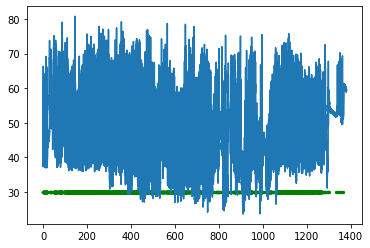

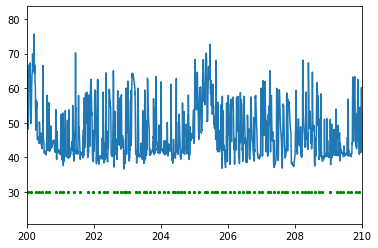

In [24]:
## plot without light data 
means_matrix = make_means_matrix(data)
xtime_p = np.arange(1, len(means_matrix)+1)/video_framerate

yPERm = means_matrix
plt.plot(xtime_p, yPERm)
plt.scatter(PER_peaks_sec, np.ones(len(PER_peaks_sec))*30, color = 'green', s = 5)
plt.show()


plt.plot(xtime_p, yPERm)
plt.scatter(PER_peaks_sec, np.ones(len(PER_peaks_sec))*30, color = 'green', s = 5)
plt.xlim(200,210)
plt.show()



C:\Python37\lib\site-packages\ipykernel_launcher.py:22: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


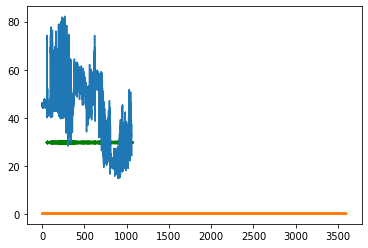

In [167]:
#raw plot
means_matrix = make_means_matrix(data)
light_means_matrix = make_means_matrix(light_data[data_index])


xtime_p = np.arange(1, len(means_matrix)+1)/video_framerate
xtime_l = np.arange(1, len(light_means_matrix)+1)/voltage_framerate
yPERm = means_matrix
ylightm = light_means_matrix

plt.plot(xtime_p, yPERm)
plt.plot(xtime_l, ylightm)
#plt.xlim(40000,120000)
plt.scatter(PER_peaks_sec, np.ones(len(PER_peaks_sec))*30, color = 'green', s = 5)
plt.scatter(light_peaks_sec, np.ones(len(light_peaks_sec))*15, color = 'red')
#plt.xlim(2100, 2200)

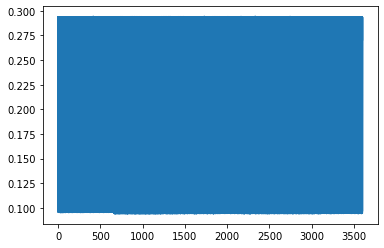

(500, 520)

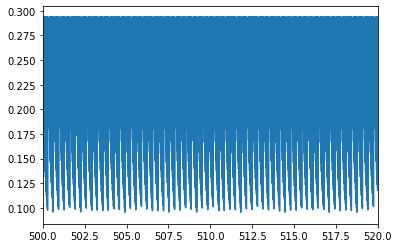

In [176]:
plt.plot(xtime_l, ylightm)
plt.show()
plt.plot(xtime_l, ylightm)
plt.xlim(500,520)

In [166]:
## use peaks data to get light to PER time rather than using PER smooth since that isn't working well (smoothed is just onsets)


light_to_PER_time = []
for p in PER_peaks_sec:
    if p > light_peaks_sec[0]: #this is in the below statement
        light_to_PER_time = np.asarray([p - light_peaks_sec[light_peaks_sec <= p][-1] for 
                                        p in PER_peaks_sec if p > light_peaks_sec[0] and 
                                        (p+1) not in light_peaks_sec and (p+1) not in 
                                        light_peaks_sec and p not in light_peaks_sec])


IndexError: index 0 is out of bounds for axis 0 with size 0

In [ ]:
# plt.plot(light_to_PER_time)
# plt.show()
# plt.hist(light_to_PER_time, width = 5)
# plt.show()
plt.scatter(range(len(light_to_PER_time)), light_to_PER_time)

In [107]:
print(p)
print(type(light_peaks_sec))
print(light_peaks_sec[light_peaks_sec <= p][-1])

82.97
<class 'numpy.ndarray'>
75.16


In [87]:
print(xtime_l[0:20])
print(xtime_p[0:20])
print(voltage_framerate)
print(video_framerate)
print(light_peaks_sec)

[ 100.  200.  300.  400.  500.  600.  700.  800.  900. 1000. 1100. 1200.
 1300. 1400. 1500. 1600. 1700. 1800. 1900. 2000.]
[ 200  400  600  800 1000 1200 1400 1600 1800 2000 2200 2400 2600 2800
 3000 3200 3400 3600 3800 4000]
100.0
200
[[  64.99   75.16   95.29  115.38  135.55  155.66  175.77  195.88  216.05
   236.1   256.31  276.38  376.66  476.79  496.96  517.09  537.22  557.31
   577.48  677.69  697.78  717.91  738.1   758.21  778.34  798.45  898.69
   998.86 1018.99 1039.12 1059.25 1079.34 1099.51 1119.6  1219.9  1239.97
  1260.12 1280.27 1300.38 1320.49 1420.73 1440.86 1460.9  1481.03 1501.16
  1521.29 1541.4  1561.55 1581.68 1681.88 1702.09 1722.18 1822.42 1842.55
  1942.7  1962.83 1982.96 2003.09 2023.2  2123.48 2143.57 2243.83 2263.98
  2364.11 2384.24 2404.37 2424.5  2524.74 2544.91 2565.   2585.11 2685.39
  2785.61 2805.65 2825.78 2845.91 2946.17 2966.32 2986.39 3006.58 3026.71
  3046.84 3147.04 3167.17 3187.26 3207.41 3227.56 3247.69 3267.78 3287.93
  3308.06 3408.23 3428.3

In [ ]:
#rest of things to do:
# 1. make raw plots
# 2. make histograms by light
# 3. get first PER (all, probe only, non-probe)
# 4. make single PER histogram by light
# 5. make probe trial histogram
# 6. get total numbers of single PER (get_single_PER_smooth)

## dictionary items that are important for other code:
data_dict = {} ##to set up dictionary to store data in for each fly
data_dict['fly-ID'] = fly_number
data_dict['framerate'] = framerate
data_dict['video number'] = str(video).strip('[]')
data_dict['date'] = str(date)
data_dict['threshold for smoothing'] = smoothed_threshold
data_dict['inputed interval (s)'] = number_interval_s

In [43]:
print(PER_peak_properties)

{'prominences': array([ 3.56164828,  4.34523037,  6.34133679, ..., 29.94029851,
       27.22355613, 29.34198572]), 'left_bases': array([    32,     32,  20172, ..., 433597, 433627, 433597], dtype=int64), 'right_bases': array([  5008,  20217,  20217, ..., 433677, 433677, 433780], dtype=int64)}


In [45]:
print(light_peak_properties.keys())


dict_keys(['peak_heights', 'prominences', 'left_bases', 'right_bases'])


In [46]:
## get onsets_indices from peak properties
light_onset_indices = light_peak_properties['left_bases']
PER_onset_indices = PER_peak_properties['left_bases']
print(len(light_onset_indices))
#originally are onsets indices? if need to convert to sec => multiple by framerate
#I think I only use onsets for light on? and I use peaks for PER? -- verify

light_on = light_onset_indices

99


In [39]:
PER_onsets_matrix_sec = get_onsets_matrix(PER_peaks_sec, data, PER_columns, identifier = 'PER')
light_onsets_matrix_sec = get_onsets_matrix(light_peaks_sec, light_data[data_index], light_columns, identifier = 'light')
    

C:\Python37\lib\site-packages\ipykernel_launcher.py:22: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


TypeError: object of type 'numpy.float64' has no len()

In [ ]:
## new onset strategy--find peaks

In [38]:
print(len(PER_peaks_sec[0]))
print(len(light_peaks_sec[0]))

5645
99


In [35]:
print(len(PER_columns))
print(np.shape(light_onsets_matrix_sec[0:10]))
print(light_onsets_matrix_sec[0:10])
print('light onsets', np.sum(light_onsets_matrix_sec))
print(light_onsets_matrix_sec[0])
print('PER onsets', np.sum(PER_onsets_matrix_sec))
print('light s', light_peaks_sec)

print(get_intensity_increase_index(light_data[data_index]))
get_intensity_increase_index(data)

1
(10, 1)
[[False]
 [False]
 [False]
 [False]
 [False]
 [False]
 [False]
 [False]
 [False]
 [False]]
light onsets 0
[False]
PER onsets 0
light s [[  64.99   75.16   95.29  115.38  135.55  155.66  175.77  195.88  216.05
   236.1   256.31  276.38  376.66  476.79  496.96  517.09  537.22  557.31
   577.48  677.69  697.78  717.91  738.1   758.21  778.34  798.45  898.69
   998.86 1018.99 1039.12 1059.25 1079.34 1099.51 1119.6  1219.9  1239.97
  1260.12 1280.27 1300.38 1320.49 1420.73 1440.86 1460.9  1481.03 1501.16
  1521.29 1541.4  1561.55 1581.68 1681.88 1702.09 1722.18 1822.42 1842.55
  1942.7  1962.83 1982.96 2003.09 2023.2  2123.48 2143.57 2243.83 2263.98
  2364.11 2384.24 2404.37 2424.5  2524.74 2544.91 2565.   2585.11 2685.39
  2785.61 2805.65 2825.78 2845.91 2946.17 2966.32 2986.39 3006.58 3026.71
  3046.84 3147.04 3167.17 3187.26 3207.41 3227.56 3247.69 3267.78 3287.93
  3308.06 3408.23 3428.36 3448.45 3468.58 3488.69 3508.82 3528.95 3549.12]]


C:\Python37\lib\site-packages\ipykernel_launcher.py:22: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


[array([], dtype=int64)]


[array([ 25784,  25800,  26363, ..., 433594, 433616, 433769], dtype=int64)]

C:\Python37\lib\site-packages\ipykernel_launcher.py:22: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


[[0.29347229]
 [0.2195282 ]
 [0.25769043]
 ...
 [0.09361267]
 [0.27108765]
 [0.26982117]]
139419


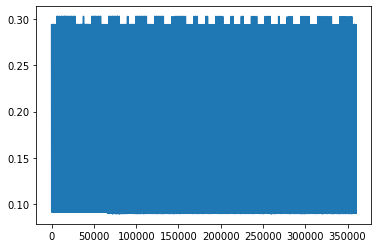

[[18.11680727]
 [18.11421155]
 [18.22096042]
 ...
 [33.40071382]
 [33.28747567]
 [33.41077223]]
4328


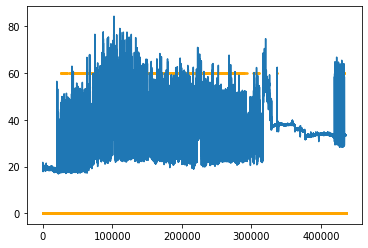

In [33]:
light_means_matrix = make_means_matrix(light_data[data_index])
print(light_means_matrix)
light_intensity_up = light_means_matrix[1:]-light_means_matrix[:-1]>=.10
print(np.sum(light_intensity_up))
plt.plot(light_means_matrix)
plt.show()

means_matrix = make_means_matrix(data)
print(means_matrix)
intensity_up = means_matrix[1:]-means_matrix[:-1]>=10
print(np.sum(intensity_up))
plt.plot(means_matrix)
plt.scatter(range(len(intensity_up)), np.array(intensity_up)*60, color = 'orange', s = 2)

In [66]:

##note intensity_up_50 = onsets_matrix and smoothed_intensity_decreases = onsets_matrix

#this may or may not work depending on if it finds the right index for light
# if it doesn't use an identifier because there is only one light column for light data
light_on = get_light_on_indices(light_onsets_matrix_sec, light_data[data_index])


def get_light_on_indices(bool_onsets_matrix, data, identifier = 'all'):
    """this will return light_on which used to be light_up_50 and it is the indices where the light onsets"""
    light_indices = get_light_index(data)
    light_on_indices = bool_onsets_matrix[:,light_indices]
    light_on = np.squeeze(np.where(light_on_indices))
    if identifier == 'light':
        
    return light_on

TypeError: object of type 'function' has no len()

In [23]:
print(PER_peaks[0:10])
print(np.array(PER_peaks[0:10])/video_framerate)

print(light_peaks[0:10])
print(np.shape(light_peaks))
print(np.shape(PER_peaks))
print(np.array(light_peaks[0:10])/voltage_framerate)

[array([   653,  16594,  20178, ..., 433615, 433664, 433761], dtype=int64)]
[[   3.265   82.97   100.89  ... 2168.075 2168.32  2168.805]]
[array([  6499,   7516,   9529,  11538,  13555,  15566,  17577,  19588,
        21605,  23610,  25631,  27638,  37666,  47679,  49696,  51709,
        53722,  55731,  57748,  67769,  69778,  71791,  73810,  75821,
        77834,  79845,  89869,  99886, 101899, 103912, 105925, 107934,
       109951, 111960, 121990, 123997, 126012, 128027, 130038, 132049,
       142073, 144086, 146090, 148103, 150116, 152129, 154140, 156155,
       158168, 168188, 170209, 172218, 182242, 184255, 194270, 196283,
       198296, 200309, 202320, 212348, 214357, 224383, 226398, 236411,
       238424, 240437, 242450, 252474, 254491, 256500, 258511, 268539,
       278561, 280565, 282578, 284591, 294617, 296632, 298639, 300658,
       302671, 304684, 314704, 316717, 318726, 320741, 322756, 324769,
       326778, 328793, 330806, 340823, 342836, 344845, 346858, 348869,
       35

In [34]:
print(len(data_all))
means_matrix = make_means_matrix(data)
light_means_matrix = make_means_matrix(light_data[data_index])

1


C:\Python37\lib\site-packages\ipykernel_launcher.py:22: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


In [ ]:
a = 60*60
print(a)
len_PER_cam = 435698  #this is the length of the means matrix
len_PER_cam/a

#121 frames per second? 

435698
360000


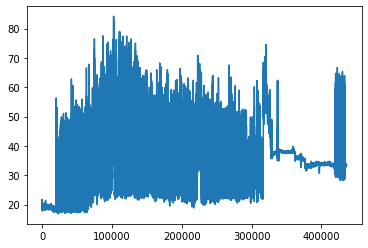

sec med 0.269989013671875


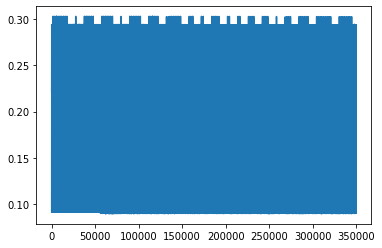

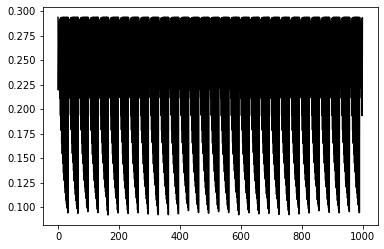

[0.29367065]
median [0.26998901]
0
(0, 1)


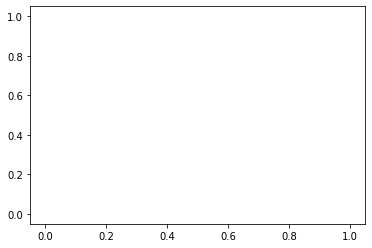

0.269989013671875


In [88]:
# plt.plot(means_matrix)
# print(len(means_matrix))
# print(len(light_means_matrix))
# plt.show()

# a = 10000
# b = 500000

# plt.plot(light_means_matrix[a:b])
# print('sec med', np.median(light_means_matrix[a:b]))
# plt.show()

# early_max = max(light_means_matrix[0:1000])
# plt.plot(light_means_matrix[0:1000], color = 'black')
# plt.show()
# print(early_max)


# a = light_means_matrix[5000000:10000000]
# light_median = np.median(light_means_matrix, axis=0)

# print('median', light_median)
# print(np.sum(a < light_median))

# print(a.shape)
# plt.plot(a)
# # plt.plot(light_means_matrix - np.median(light_means_matrix)) #[5000000:10000000]) #[0:len(means_matrix)])
# #plt.ylim(.27, .33)
# # plt.xlim(0, 100)
# plt.show()
# print(np.median(light_means_matrix))

In [87]:
print(light_median)
print(early_max)

[0.26998901]
[0.29367065]


(360000, 1)
(360000, 1)
99


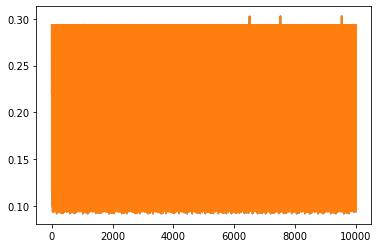

In [118]:
# plt.plot(light_means_matrix[0:10000])
# print(np.shape(light_means_matrix))

# squeeze_column = np.squeeze(light_means_matrix) 

# #just run find peaks on anything over median?

# plt.plot(light_means_matrix[0:10000])
# print(np.shape(light_means_matrix))

# squeeze_column = np.squeeze(light_means_matrix) 

# #just run find peaks on anything over median?

# # light_peaks, _ = scipy.signal.find_peaks(squeeze_column, height = light_median[0], prominence = .1, distance = 10)
# # print(len(light_peaks))
# light_peaks, _ = scipy.signal.find_peaks(squeeze_column, height = early_max[0]+.001, prominence = .1, distance = 10)
# print(len(light_peaks))

1


(0.26, 0.31)

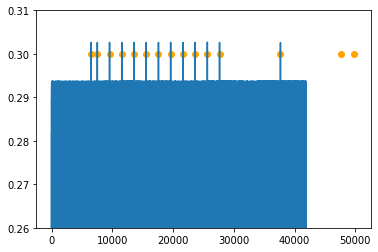

In [30]:
#check light_peaks!!
print(len(light_peaks))

##if getting errors it's because reran light peaks and its indexing weird

plt.plot(light_means_matrix[0:41902])
plt.scatter(light_peaks[0][0:15], np.ones(len(light_peaks[0][0:15]))*.3, color = 'orange')
plt.ylim(.26,.31)

1
[ 64.99  75.16  95.29 115.38 135.55 155.66 175.77 195.88 216.05 236.1
 256.31 276.38 376.66 476.79 496.96]
[ 6499  7516  9529 11538 13555 15566 17577 19588 21605 23610 25631 27638
 37666 47679 49696]


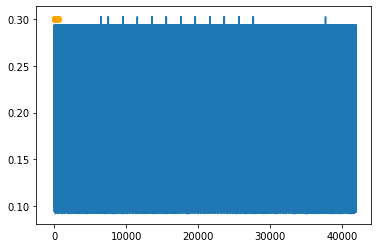

In [35]:
#check light_peaks!!
print(len(light_peaks))
print(np.array(light_peaks[0][0:15])/(voltage_framerate))
print(np.array(light_peaks[0][0:15]))


##if getting errors it's because reran light peaks and its indexing weird
end = int(41902)
plt.plot(np.array(light_means_matrix[0:end]))  #its complicated to plot this for seconds...
## voltage framerate is off by 10 should be *10
plt.scatter(np.array(light_peaks[0][0:15])/voltage_framerate, np.ones(len(light_peaks[0][0:15]))*.3, color = 'orange')
#plt.ylim(.26,.31)

In [ ]:
print(len(light_peaks))
#plt.scatter(np.arange(len(light_peaks[6000:8000])), light_peaks[6000:8000])
plt.plot(light_means_matrix[6450:6550], color = 'orange')

5645


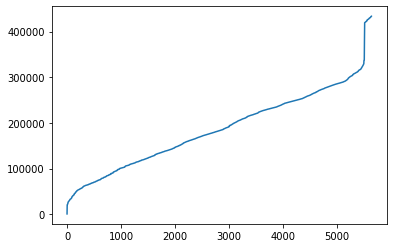

[   677   1089   1279   1549   2339   2669   2989   3527   3723   5076
   5959   6499   7516   7718   7883   8312   8762   9529  10451  10614
  11208  11536  11841  12270  12495  12635  12763  12957  13182  13555
  14046  14471  15566  15766  16168  17581  17876  18039  18443  18930
  19165  19468  19588  20908  21448  21605  22073  22890  23294  23610
  24874  25631  25996  26493  26625  27223  27343  27638  27772  28640
  28939  29104  29302  29492  30088  30189  30676  30946  31047  31375
  32033  34081  34211  34316  35069  35271  35638  36360  36496  36628
  36756  36983  37123  37513  37666  38132  38233  38342  38497  38936
  39365  39955  40182  40549  40654  41077  41277  41512  41772  41902
  42197  42302  43354  43459  44243  45371  45691  46425  46681  46891
  47046  47679  48966  49496  49696  50616  51596  51709  51864  52229
  52429  52588  53093  53258  53388  53514  53718  53951  54139  54306
  54533  54968  55329  55731  55886  56519  57278  57641  57748  58111
  5824

In [95]:
x = np.arange(0,len(PER_peaks[0]))
print(len(PER_peaks[0]))
plt.plot(x, PER_peaks[0]) #[0:1000])
plt.show()
print((light_peaks))
#plt.plot(light_peaks[0:10000])

In [ ]:
#6-20-19 edit for scipy peaks--find the onset of the peaks for light and PER

###----Set up stage----
#date = str(raw_input("enter date (MMDDYY): ")) ##change to just input when convert to python 3
#framerate = int(input("enter framerate (# ms between frames (10 or 33)): "))
#smoothed_threshold = float(input("enter thresholding amount for PER (typically 1 (up to 2.5)): "))
#binsize = int(input("enter binsize for histograms in ms (typically 250): "))


    
    
    


#     #this gives just the column numbers that contain the word mean
#     mean_column = []
#     for row in range(len(data)):
#         for column in range(len(data[row])):
#             if is_column_mean(data, row, column):
#                 mean_column.append(column)
#     print('number of columns with means: ', len(mean_column))
    
#     #get the columns that have means and turn them into a new matrix
#     columns = []
#     means_matrix = []
#     for item in mean_column:
#         columns.append(get_means(data, item))
#     means_matrix = np.vstack(columns).T # converts the list of arrays into a matrix ".T" makes it report tall   
    
#     #get the titles for columns that have means and turn them into a new array
#     title_collection = []
#     mean_titles = []
#     for t in mean_column:
#         title_collection.append(get_header(data, t))
#     mean_titles = np.vstack(title_collection).T
#     print(mean_titles)
    
    
#     #################  BRUKER   #####################
#     #### changing this to light mean titles --look at the data that is voltage recording
    
#     light_title_collection = []
#     light_mean_titles = []
#     for t in mean_column:
#         title_collection.append(get_header(light_data[data_index], t)) ##make sure this matches with mult flies
#     light_mean_titles = np.vstack(light_title_collection).T
#     print(light_mean_titles)
    
#     ##----designate columns by light---- (PER designation is later)
#     #find the column number for "light" or "Light"
    
#     ##########  BRUKER ########################
#     #### change mean titles here to be light_mean_titles to look at the other data
#     light_indices = []
#     for row in range(len(mean_titles)):
#         for column in range(len(light_mean_titles[row])):
#             if is_column_light(light_mean_titles, row, column):
#                 light_indices.append(column)
#     light_indices = np.array(light_indices)
#     light_indices_int = int(light_indices) ##to convert to integer so light_up_50 ends up with only one list and not a list of zeros
#     print(light_indices_int)
    
#     ### maybe I could add the light column to the other matrix?
#     ## I need to sort out the different framerates
    
    
#     #get the columns that have means and use them to get the peaks
#     ##get PER peaks
#     columns = []
#     peaks_matrix = []
#     PER_peaks = []
#     for mean_index in range(len(mean_column)):
#         squeeze_column = []
#         single_column = []
#         single_column = get_means(data, mean_column[mean_index])
#         columns.append(single_column)  #collects the means in columns
#         squeeze_column = np.squeeze(single_column)  #to get each element out of their own array and into one array with all elements
# #         if is_column_light(mean_titles, 0, mean_index):
# #             peaks, _ = scipy.signal.find_peaks(squeeze_column, prominence = .5) #, prominence = .01) #7.8.20 changing prominence from .5 to .25 #9.10.19 changed prominence from 3 to 1
# #             print('light column', mean_titles[0][mean_index])
# #         else:
#         peaks, _ = scipy.signal.find_peaks(squeeze_column*-1, prominence = 3, distance = 15) #distance is req frames between peaks
#         #print('not light')     
#         all_peaks.append(peaks)
#         print('peaks length', len(peaks))
#     print('all_peaks shape', np.shape(all_peaks))
    
#     ## BRUKER  ############
#     ### run this seperate 
#     ## then merge into one all_peaks with light as a header and PER as a header
#     # sort out times later...when determine framerate of the camera
    
#     columns = []
#     peaks_matrix = []
#     PER_peaks = []
#     for mean_index in range(len(mean_column)):
#         squeeze_column = []
#         single_column = []
#         single_column = get_means(data, mean_column[mean_index])
#         columns.append(single_column)  #collects the means in columns
#         squeeze_column = np.squeeze(single_column)  #to get each element out of their own array and into one array with all elements
#         if is_column_light(mean_titles, 0, mean_index):
#             peaks, _ = scipy.signal.find_peaks(squeeze_column, prominence = .5) #, prominence = .01) #7.8.20 changing prominence from .5 to .25 #9.10.19 changed prominence from 3 to 1
#             print('light column', mean_titles[0][mean_index])
#         else:
#             peaks, _ = scipy.signal.find_peaks(squeeze_column*-1, prominence = 3, distance = 15) #distance is req frames between peaks
#             print('not light')     
#         all_peaks.append(peaks)
#         print('peaks length', len(peaks))
#     print('all_peaks shape', np.shape(all_peaks))
    
    
#     ##get smoothed means matrix
#     #call each column to perform the vectorized smoothing average over 3 frames to see if it changes intensity
#         ##Essentially take windowsize number of columns that are off by 1 until get to windowsize (in this case=3)
#         ##[begin:end:stride] end is exclusive so if you want to include item #n write n+1. -1 is second to last
#         ###NOTE: this will not give a value for the last 2 items (will shorten the array by 2) 
#     smoothed_means_matrix = []
#     smoothed_means_matrix = means_matrix[:-2]/3 + means_matrix[1:-1]/3 + means_matrix[2:]/3
#     #to just see if previous value greater than next value of smoothened array--if the intensity drops
#     smoothed_intensity_decreases = []
#     smoothed_intensity_decreases = smoothed_means_matrix[:-1]>(smoothed_means_matrix[1:] + smoothed_threshold)
#     smoothed_intensity_decreases = smoothed_intensity_decreases.T  #want to stack the other way
    
#     #to just see if previous value smaller than next value of smoothened array--if the intensity increases
#     smoothed_intensity_increases = []
#     smoothed_intensity_increases = smoothed_means_matrix[:-1]<(smoothed_means_matrix[1:] + smoothed_threshold)
#     smoothed_intensity_increases = smoothed_intensity_increases.T

#     smoothed_increase_index = []
#     for column in range(len(smoothed_intensity_increases)):
#         true_indices = np.where(smoothed_intensity_increases[column])
#         smoothed_increase_index.append(np.squeeze(true_indices))
            
    
#     smoothed_decrease_index = []
#     for column in range(len(smoothed_intensity_decreases)):
#         true_indices = np.where(smoothed_intensity_decreases[column])
#         smoothed_decrease_index.append(np.squeeze(true_indices))
           
    
    
    
#     ##unsmoothed matrix and unthresholded
#     intensity_decreases = []
#     intensity_decreases = means_matrix[:-1]>means_matrix[1:]
#     intensity_increases = []
#     intensity_increases = means_matrix[:-1]<means_matrix[1:]
#     #with thresholding 
#     ##look for a difference of 50 units (lower sometimes gives artificial intervals)
#     intensity_down_50 = []
#     intensity_down_50 = means_matrix[:-1]-means_matrix[1:]>=25  #changing this to 25 because I should be able to clean out doubles with peaks and I'd rather not miss one
#     intensity_up_50 = []
#     intensity_up_50 = means_matrix[1:]-means_matrix[:-1]>=10  #9.10.19 changed from 25 to 10 to see if I can get the light pulses
    
#     intensity_up_50 = intensity_up_50.T
#     up_50_index = []
#     for column in range(len(intensity_up_50)):
#         true_indices = np.where(intensity_up_50[column])
#         up_50_index.append(np.squeeze(true_indices))
    
    
#     #find onset of peaks from scipy peaks and intensity changes
#     #onset is found by looking at the frames of peaks and looking for the smoothed_intensity change before that
#     #for PER looking for a decrease, for light looking for an increase
#     #each per or light can be accessed by means_matrix[:, index of per (column)]
#     #I want to look at the peaks values of each column and compare them to the intensity changes of each column (depending on if it is light or not)
#     #light index is light_indices
    
#     all_onsets_matrix = []
#     for mean_item_index in range(len(all_peaks)): #mean item index is light or PERs
#         onsets = []
#         onset = [] #this should be cleared more often than this, but really I just need to initialize it for my checks
#         if mean_item_index == light_indices: #if the index corresponds to light index then use intensity up 50
#             for i in range(len(all_peaks[mean_item_index])):
#                 possible_onset = []
#                 new_possible_onset = []
#                 if up_50_index[mean_item_index].size > 1: #if it exists and has more than one element
#                     for j in range(len(up_50_index[mean_item_index])):
#                         if up_50_index[mean_item_index][j] < all_peaks[mean_item_index][i] and all_peaks[mean_item_index][i]-up_50_index[mean_item_index][j] < 50: #if the value is less than the peak and the onset isn't far from peak (here 20 frames (~660ms for 33ms framerate))
#                             possible_onset.append(up_50_index[mean_item_index][j]) #make a list of possible onsets
#                         else:
#                             possible_onset.append(0) #hopefully this will fix if the onsets and peaks don't match
#                     if i == 0: #if we are on the first element in peaks_PER
#                         if possible_onset: #this will check if possible_onset is an empty list, if it is it will fail
#                             onset = possible_onset[0]  #then the onset is the first in the list... this could fail sometimes, but hopefully with frame limit it won't
#                     if i > 0: #if it is not the first element
#                         #remove the possible onsets that are before the previous peak then take the first one
#                         for onset_index in possible_onset:
#                             if onset_index > all_peaks[mean_item_index][i-1]:
#                                 new_possible_onset.append(onset_index)
#                                 onset = new_possible_onset[0]
#                     #to prevent appending empty lists
#                     if onset:  #this fails if onset is an empty list and will not append anything
#                         onsets.append(onset)  #these are light but will add PER below
#         else: #the index is for a PER
#             for i in range(len(all_peaks[mean_item_index])):
#                 possible_onset = []
#                 new_possible_onset = []
#                 if smoothed_decrease_index[mean_item_index].size > 1: #if it is not empty or one element
#                     for j in range((smoothed_decrease_index[mean_item_index].size)):
#                         if smoothed_decrease_index[mean_item_index][j] < all_peaks[mean_item_index][i] and all_peaks[mean_item_index][i] - smoothed_decrease_index[mean_item_index][j] < 50: #if the value is less than the peak and the onset isn't far from peak (here 20 frames (~660ms for 33ms framerate))
#                             possible_onset.append(smoothed_decrease_index[mean_item_index][j]) #make a list of possible onsets 
#                         else:
#                             possible_onset.append(0) #hopefully this will fix if the onsets and peaks don't match    
#                     if i == 0: #if we are on the first element in peaks_PER
#                         if possible_onset: #checks to make sure there is something in possible_onset
#                         #onset = possible_onset[0]  #then the onset is the first in the list... this could fail sometimes, but hopefully with frame limit it won't
#                             onset = int(np.median(possible_onset)) #needs to be int because it is an index
#                     if i > 0: #if it is not the first element
#                         #remove the possible onsets that are before the previous peak then take the first one
#                         for onset_index in possible_onset:
#                             if onset_index > all_peaks[mean_item_index][i-1]:  #I need to fix this in case it is not >. I think skip otherwise?
#                                 new_possible_onset.append(onset_index)
#                                 #onset = new_possible_onset[0]  #might be better if this doesn't have to collect the first one everytime, but it should work fine and eliminates the issue if the if statement is not true
#                                 onset = int(np.median(new_possible_onset)) #needs to be int because it is an index
#                     #to prevent appending empty lists
#                     if onset:  #this fails if onset is an empty list and will not append anything
#                         onsets.append(onset)
#         all_onsets_matrix.append(onsets)        
        
        
    
#     #convert all_onsets into a boolean
#     onsets_boolean = []
#     for index in range(len(all_onsets_matrix)):
#         boolean_single = []
#         for i in range(len(columns[0])): #because it has all of the elements not just the ones with peaks
#             if i in all_onsets_matrix[index]: #look through each index and see if it is in the onsets list
#                 boolean_single.append(True) #if it is replace with true
#             else:
#                 boolean_single.append(False)
#         onsets_boolean.append(boolean_single)
#     onsets_matrix = np.vstack(onsets_boolean).T  #do I need this?
   
#     print('bool peaks', np.shape(onsets_boolean))
#     print('col shape', np.shape(columns))
#     print('peaks matrix shape', np.shape(peaks_matrix))
#     #convert all_peaks boolean to matrix with columns
   
    #needs to be a boolean matrix where TRUE is the index in all_peaks (columns are maintained...currently columns are rows)  
    #print(np.shape(peaks_matrix))


    
    
    
    
    
    
    
    
    
    
    
    
    
    
    
    
    
    
    
    
    
# #TO USE INTENSITY UP 50 FOR LIGHT_UP_50   
#     light_up_50 = intensity_up_50[:,light_indices_int]
#     light_up_50 = np.squeeze(np.where(light_up_50))
#     print('light up 50 pre (using intensity): ', light_up_50)
    
    #convert back to variables used in the other code   
    #fix this later so it is less confusing. this is messy
    intensity_up_50 = onsets_matrix #rewrite variable names and change functions later
    smoothed_intensity_decreases = onsets_matrix  ##fix these variables later, 
                   #but for now make everything the same so different functions will use the same peaks info
        
###  TO USE ONSETS FOR LIGHT UP 50    
    light_up_50 = onsets_matrix[:,light_indices_int]   
    light_up_50 = np.squeeze(np.where(light_up_50))
    print('light up 50-pre: ', light_up_50)
    
    
    #In case the light is too dim to get any responses
    if interval_ms != 0 and len(light_up_50) < 1:  #!= is to eliminate no light conditions
        #redo the find peaks with lower threshold requirement--this would require a lot of duplication. I should make functions
        print("ERROR: light up 50 threshold is too low or light is absent")
    
    
    
    #ignore second peak for double flash
    if double_flash == True:
        first_flash_light_up_50 = []
        for i in range(len(light_up_50)-1):
            if i == 0: #always take the first light pulse
                first_flash_light_up_50.append(int(light_up_50[i]))
            if i > 0: #ignore first flash
                if (light_up_50[i+1]-light_up_50[i]) < time_to_discount/framerate:
                    first_flash_light_up_50.append(int(light_up_50[i]))  #ignore second flash
                    print('double, ignore: ', light_up_50[i+1])
                #to get ones where there is no double flash or it isn't captured
                elif ((light_up_50[i+1]-light_up_50[i]) > time_to_discount/framerate) and ((light_up_50[i]-light_up_50[i-1]) > time_to_discount/framerate):
                    first_flash_light_up_50.append(int(light_up_50[i]))
                    print('single flash')
        all_light_up_50 = light_up_50 # store all the light still, this will be saved in a dict further down
        
        light_up_50 = np.array(first_flash_light_up_50)  #overwrite previous light settings
        print('light up 50-post: ', light_up_50)
        
    
    
    
    

    
    
    #it would be nicer if these were functions so it could scale based on the number of PERs detected
    
    ##---functions that give analysis AND that need INPUT ---
    
    #get a list of PER to run through (and make the associated fly number list using data_all
    PER_indices = []
    for row in range(len(mean_titles)):
        for column in range(len(mean_titles[row])):
            if is_column_PER(mean_titles, row, column):
                PER_indices.append(column)
    PER2_indices = []
    for row in range(len(mean_titles)):
        for column in range(len(mean_titles[row])):
            if is_column_PER2(mean_titles, row, column):
                PER2_indices.append(column)
    PER3_indices = []
    for row in range(len(mean_titles)):
        for column in range(len(mean_titles[row])):
            if is_column_PER3(mean_titles, row, column):
                PER3_indices.append(column)             
    PER4_indices = []
    for row in range(len(mean_titles)):
        for column in range(len(mean_titles[row])):
            if is_column_PER4(mean_titles, row, column):
                PER4_indices.append(column)
    
    PER5_indices = []
    for row in range(len(mean_titles)):
        for column in range(len(mean_titles[row])):
            if is_column_PER5(mean_titles, row, column):
                PER5_indices.append(column)
                
    PER6_indices = []
    for row in range(len(mean_titles)):
        for column in range(len(mean_titles[row])):
            if is_column_PER6(mean_titles, row, column):
                PER6_indices.append(column)
    
    PER7_indices = []
    for row in range(len(mean_titles)):
        for column in range(len(mean_titles[row])):
            if is_column_PER7(mean_titles, row, column):
                PER7_indices.append(column)
    PER8_indices = []
    for row in range(len(mean_titles)):
        for column in range(len(mean_titles[row])):
            if is_column_PER8(mean_titles, row, column):
                PER8_indices.append(column)
                
    PER9_indices = []
    for row in range(len(mean_titles)):
        for column in range(len(mean_titles[row])):
            if is_column_PER9(mean_titles, row, column):
                PER9_indices.append(column)
    
    PER10_indices = []
    for row in range(len(mean_titles)):
        for column in range(len(mean_titles[row])):
            if is_column_PER10(mean_titles, row, column):
                PER10_indices.append(column)
                     
    PER11_indices = []
    for row in range(len(mean_titles)):
        for column in range(len(mean_titles[row])):
            if is_column_PER11(mean_titles, row, column):
                PER11_indices.append(column)
                
    PER12_indices = []
    for row in range(len(mean_titles)):
        for column in range(len(mean_titles[row])):
            if is_column_PER12(mean_titles, row, column):
                PER12_indices.append(column)
    
    PER13_indices = []
    for row in range(len(mean_titles)):
        for column in range(len(mean_titles[row])):
            if is_column_PER13(mean_titles, row, column):
                PER13_indices.append(column)
    
    PER14_indices = []
    for row in range(len(mean_titles)):
        for column in range(len(mean_titles[row])):
            if is_column_PER14(mean_titles, row, column):
                PER14_indices.append(column)
    
    PER15_indices = []
    for row in range(len(mean_titles)):
        for column in range(len(mean_titles[row])):
            if is_column_PER15(mean_titles, row, column):
                PER15_indices.append(column)
    
    PER16_indices = []
    for row in range(len(mean_titles)):
        for column in range(len(mean_titles[row])):
            if is_column_PER16(mean_titles, row, column):
                PER16_indices.append(column)
    
    PER17_indices = []
    for row in range(len(mean_titles)):
        for column in range(len(mean_titles[row])):
            if is_column_PER17(mean_titles, row, column):
                PER17_indices.append(column)
    PER18_indices = []
    for row in range(len(mean_titles)):
        for column in range(len(mean_titles[row])):
            if is_column_PER18(mean_titles, row, column):
                PER18_indices.append(column)
    PER19_indices = []
    for row in range(len(mean_titles)):
        for column in range(len(mean_titles[row])):
            if is_column_PER19(mean_titles, row, column):
                PER19_indices.append(column)
    PER20_indices = []
    for row in range(len(mean_titles)):
        for column in range(len(mean_titles[row])):
            if is_column_PER20(mean_titles, row, column):
                PER20_indices.append(column)



    ##---functions that give analysis AND that need INPUT ---
    print(video)


    #get a list of PER to run through (and make the associated fly number list using data_all
    PER_list = []
    fly_id_list = []
    if len(PER_indices) > 0:
        PER_list.append(PER_indices)        
        fly_id = fly_number_list[data_index][0]
        fly_id_list.append(fly_id)
    if len(PER2_indices) > 0:
        PER_list.append(PER2_indices)        
        fly_id = fly_number_list[data_index][1]
        fly_id_list.append(fly_id)
    if len(PER3_indices) > 0:
        PER_list.append(PER3_indices)        
        fly_id = fly_number_list[data_index][2]
        fly_id_list.append(fly_id)
    if len(PER4_indices) > 0:
        PER_list.append(PER4_indices)
        fly_id = fly_number_list[data_index][3]
        fly_id_list.append(fly_id)
        
    if len(PER5_indices) > 0:
        PER_list.append(PER5_indices)
        fly_id = fly_number_list[data_index][4]
        fly_id_list.append(fly_id)
        
    if len(PER6_indices) > 0:
        PER_list.append(PER6_indices)
        fly_id = fly_number_list[data_index][5]
        fly_id_list.append(fly_id)
        
    if len(PER7_indices) > 0:
        PER_list.append(PER7_indices)
        fly_id = fly_number_list[data_index][6]
        fly_id_list.append(fly_id)
        
    if len(PER8_indices) > 0:
        PER_list.append(PER8_indices)
        fly_id = fly_number_list[data_index][7]
        fly_id_list.append(fly_id)
        
    if len(PER9_indices) > 0:
        PER_list.append(PER9_indices)
        fly_id = fly_number_list[data_index][8]
        fly_id_list.append(fly_id)
    if len(PER10_indices) > 0:
        PER_list.append(PER10_indices)
        fly_id = fly_number_list[data_index][9]
        fly_id_list.append(fly_id)
    if len(PER11_indices) > 0:
        PER_list.append(PER11_indices)
        fly_id = fly_number_list[data_index][10]
        fly_id_list.append(fly_id)
    if len(PER12_indices) > 0:
        PER_list.append(PER12_indices)
        fly_id = fly_number_list[data_index][11]
        fly_id_list.append(fly_id)
    if len(PER13_indices) > 0:
        PER_list.append(PER13_indices)
        fly_id = fly_number_list[data_index][12]
        fly_id_list.append(fly_id)
    if len(PER14_indices) > 0:
        PER_list.append(PER14_indices)
        fly_id = fly_number_list[data_index][13]
        fly_id_list.append(fly_id)
    if len(PER15_indices) > 0:
        PER_list.append(PER15_indices)
        fly_id = fly_number_list[data_index][14]
        fly_id_list.append(fly_id)
    if len(PER16_indices) > 0:
        PER_list.append(PER16_indices)
        fly_id = fly_number_list[data_index][15]
        fly_id_list.append(fly_id)
    if len(PER17_indices) > 0:
        PER_list.append(PER17_indices)
        fly_id = fly_number_list[data_index][16]
        fly_id_list.append(fly_id)
    if len(PER18_indices) > 0:
        PER_list.append(PER18_indices)
        fly_id = fly_number_list[data_index][17]
        fly_id_list.append(fly_id)
    if len(PER19_indices) > 0:
        PER_list.append(PER19_indices)
        fly_id = fly_number_list[data_index][18]
        fly_id_list.append(fly_id)
    if len(PER20_indices) > 0:
        PER_list.append(PER20_indices)
        fly_id = fly_number_list[data_index][19]
        fly_id_list.append(fly_id)

    #determine if want split raw plots
    #     split = str(raw_input("enter y to make ONLY split raw plots, b to make split and full plots, n for no plots: "))
    #     time_post_light_ms = int(input("enter ms post light to start checking for first PER (typically 1000): "))

    #chosen setting
    split = 'y'
    time_post_light_ms = 1000
    save = 'y'
    save_raw = 'y'
    save_hist = 'y'
    save_first_PER = 'y'
    save_single_hist = 'y'
    save_probe = 'y'
    save_total = 'y'
    save_anticipation = 'y'


#set previously
#interval_ms = int(input("enter interval in ms (if RANDOM or NO LIGHT type 0): "))


    total_PER_smooth = []

    #if normal interval
    if interval_ms != 0:
        #print("normal")
        probe_ms = 3 * interval_ms
        #since interval_s only for title
        interval_s = str(int(interval_ms/1000)) + 's' 
        number_interval_s = int(interval_ms/1000)
        probe_ms_binlength = make_bins(probe_ms, binsize)
        interval_ms_binlength = make_bins(interval_ms, binsize)

        #run through PER list and execute each analysis function
        for index in range(len(PER_list)):

            PER_index = PER_list[index]
            #fly_number = fly_number_list[index]
            fly_number = fly_id_list[index]

            data_dict = {} ##to set up dictionary to store data in for each fly
            data_dict['fly-ID'] = fly_number
            data_dict['framerate'] = framerate
            data_dict['video number'] = str(video).strip('[]')
            data_dict['date'] = str(date)
            data_dict['threshold for smoothing'] = smoothed_threshold
            data_dict['inputed interval (s)'] = number_interval_s
            
            #store all flashes if there is a double flash
            if double_flash == True:
                data_dict['all light without second flash removal'] = all_light_up_50
                data_dict['light with second flash removal'] = light_up_50

            #make raw plots
            make_raw_plots (PER_index, fly_number, split, save_raw)

            #make histogram by light
            make_histogram_by_light (PER_index, fly_number, save_hist)

            #first PER
            get_first_PER (PER_index, fly_number, time_post_light_ms, save_first_PER)
            get_first_PER_probe_only (PER_index, fly_number, time_post_light_ms, save_first_PER)
            get_first_PER_no_probe (PER_index, fly_number, time_post_light_ms, save_first_PER)

            #make single histogram by light
            make_single_PER_histogram_by_light (PER_index, fly_number, save_single_hist)

            #get probe information
            probe_trial_histogram (PER_index, fly_number, save_probe)

            #get total numbers single PER
            single_PER_smooth = []
            single_PER_smooth = get_single_PER_smooth_totals(PER_index, fly_number, save_total)
            total_PER_smooth.append(single_PER_smooth)
            
            

            #get anticipation rate
            get_anticipation_non_random_trial (PER_index, fly_number, save_anticipation)

             #make title
            title = make_title(date, video, fly_number, interval_s)

            #save dictionary
            #Path = '/Users/ashsm/Documents/python analysis/new-code-test'
            dictionaryPath = SavePath + "/" + str(date) + "/dictionary"
            if os.path.exists(dictionaryPath):
                print('folder there')
            else:
                os.makedirs(dictionaryPath)
            with open(os.path.join(dictionaryPath, str(title) + '_dict.pickle'), 'wb') as outfile:
                pickle.dump(data_dict, outfile)

        #to save total PER
        if save_total == 'y':
            header_PER_total = fly_number_list[data_index]
            all_PER_total = [header_PER_total, total_PER_smooth]
            #Path = '/Users/ashsm/Documents/python analysis/new-code-test'
            totalPERPath = SavePath + "/" + str(date) + "/total single PER"
            if os.path.exists(totalPERPath):
                print('folder there')
            else:
                os.makedirs(totalPERPath)
              ##DO NOT CHANGE THIS SAVE TO TITLE
            np.savetxt(os.path.join(totalPERPath, str(date) + str(video).strip('[]') + 'all_flyID' + interval_s + 'total_single_PER.txt'), all_PER_total, fmt='%s')


    #in case of no light flashes or random
    elif interval_ms == 0:
        #ask = str(raw_input("Is this a no light trial? y for yes, r for random "))
        if ask[data_index] == 'y':
            print("no light condition")
            interval_s = '_no_light_condition_'
            total_PER_smooth = []
            for index in range(len(PER_list)):
                data_dict = {} ##to set up dictionary to store data in for each fly
                

                PER_index = PER_list[index]
                #fly_number = fly_number_list[index]
                number_interval_s = int(interval_ms/1000)
                fly_number = fly_id_list[index]
                
                #make raw plots
                make_raw_plots(PER_index, fly_number, save_raw, split)
                
                data_dict['fly-ID'] = fly_number
                data_dict['framerate'] = framerate
                data_dict['video number'] = str(video).strip('[]')
                data_dict['date'] = str(date)
                data_dict['threshold for smoothing'] = smoothed_threshold
                data_dict['inputed interval (s)'] = number_interval_s

                #get total # single PER
                PER_index = np.asarray(PER_index)
                PER_index_int = int(PER_index) ##to convert to integer so ends up with only one list and not a list of zeros
                PER_smooth_out = np.nonzero(smoothed_intensity_decreases[:,PER_index_int])  #light_indices specifies light column
                PER_smooth_out = PER_smooth_out[0]
                PER_smooth_out = np.asarray(PER_smooth_out)
                data_dict['frames PER out--smoothed'] = PER_smooth_out
                
                single_PER_smooth = []
                single_PER_smooth = get_single_PER_smooth_totals(PER_index, fly_number, save_total)
                total_PER_smooth.append(single_PER_smooth)

                 #make title
                title = make_title(date, video, fly_number, interval_s)

                #save dictionary
                
                dictionaryPath = SavePath + "/" + str(date) + "/dictionary"
                if os.path.exists(dictionaryPath):
                    print('dictionary folder there')
                else:
                    os.makedirs(dictionaryPath)
                with open(os.path.join(dictionaryPath, str(title) + '_dict.pickle'), 'wb') as outfile:
                    pickle.dump(data_dict, outfile)

            #to save total PER
            if save_total == 'y':
                header_PER_total = fly_number_list[data_index]
                all_PER_total = [header_PER_total, total_PER_smooth]
                #Path = '/Users/ashsm/Documents/python analysis/new-code-test'
                totalPERPath = SavePath + "/" + str(date) + "/total single PER"
                if os.path.exists(totalPERPath):
                    print('folder there')
                else:
                    os.makedirs(totalPERPath)
                  ##DO NOT CHANGE THIS SAVE TO TITLE
                np.savetxt(os.path.join(totalPERPath, str(date) + str(video).strip('[]') + 'all_flyID' + interval_s + 'total_single_PER.txt'), all_PER_total, fmt='%s')
            else:
                print('total PER not saved')
            #get video information
            #get_video_information(save_probe)




        if ask[data_index] == 'r':
            print("random condition")
            #add random to titles
            interval_ms = 11000
            interval_s = 'random'
            interval_ms_binlength = make_bins(interval_ms, binsize)
            probe_ms_binlength = make_bins(interval_ms, binsize)
            #run through PER list and execute each analysis function
            for index in range(len(PER_list)):
                data_dict = {} ##to set up dictionary to store data in for each fly
                data_dict['inputed interval (s)'] = interval_s
                data_dict['video number'] = str(video).strip('[]')
                PER_index = PER_list[index]
               # fly_number = fly_number_list[index]
                fly_number = fly_id_list[index]
                data_dict['fly-ID'] = fly_number
                #make raw plots
                make_raw_plots(PER_index, fly_number, save_raw, split)

                #make histogram by light
                make_histogram_by_light (PER_index, fly_number, save_hist)

                #first PER
                get_first_PER (PER_index, fly_number, time_post_light_ms, save_first_PER)

                #make single histogram by light
                make_single_PER_histogram_by_light (PER_index, fly_number, save_single_hist)

                #get total numbers single PER
                single_PER_smooth = []
                single_PER_smooth = get_single_PER_smooth_totals(PER_index, fly_number, save_total)
                total_PER_smooth.append(single_PER_smooth)

                #get anticipation rate
                get_anticipation_random_trial (PER_index, fly_number, save_anticipation)

                 #make title
                title = make_title(date, video, fly_number, interval_s)

                #save dictionary
                #Path = '/Users/ashsm/Documents/python analysis/new-code-test'
                dictionaryPath = SavePath + "/" + str(date) + "/dictionary"
                if os.path.exists(dictionaryPath):
                    print('folder there')
                else:
                    os.makedirs(dictionaryPath)
                with open(os.path.join(dictionaryPath, str(title) + '_dict.pickle'), 'wb') as outfile:
                    pickle.dump(data_dict, outfile)

            #to save total PER
            if save_total == 'y':
                header_PER_total = fly_number_list[data_index]
                all_PER_total = [header_PER_total, total_PER_smooth]
                #Path = '/Users/ashsm/Documents/python analysis/new-code-test'
                totalPERPath = SavePath + "/" + str(date) + "/total single PER"
                if os.path.exists(totalPERPath):
                    print('folder there')
                else:
                    os.makedirs(totalPERPath)
                  ##DO NOT CHANGE THIS SAVE TO TITLE
                np.savetxt(os.path.join(totalPERPath, str(date) + str(video).strip('[]') + 'all_flyID' + interval_s + 'total_single_PER.txt'), all_PER_total, fmt='%s')


            #get video information
            get_video_information(save_probe)


In [ ]:
print(peaks)
print(len(all_peaks))
print(all_peaks[1])
print(peaks_matrix)
print(video)
print(light_up_50)